In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import logging
import glob
import pathlib
from copy import deepcopy
import geopandas as gpd
import xarray as xr
import numpy as np
import pandas as pd

import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, Callback

from torchmetrics import MeanAbsolutePercentageError
import matplotlib.pyplot as plt

from darts.models import TFTModel
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.datasets import AirPassengersDataset, MonthlyMilkDataset, ElectricityDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler, StaticCovariatesTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import warnings

warnings.filterwarnings("ignore")

logging.disable(logging.CRITICAL)

In [4]:
pd.read_csv("./some_tft_res.csv")['NSE'].median()

0.6351372748613358

In [4]:
pd.read_csv("./some_tft_res_multi.csv")["NSE"].median()

0.9658951722085476

In [3]:
# setting device on GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
print()

# Additional Info when using cuda
if device.type == "cuda":
    print(torch.cuda.get_device_name(0))
    print("Memory Usage:")
    print("Allocated:", round(torch.cuda.memory_allocated(0) / 1024**3, 1), "GB")
    print("Cached:   ", round(torch.cuda.memory_reserved(0) / 1024**3, 1), "GB")


meteo_input = ["prcp_e5l", "t_max_e5l", "t_min_e5l"]
# q_mm_day or lvl_sm
hydro_target = "q_mm_day"

Using device: cuda

NVIDIA GeForce RTX 3080 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [5]:
if (hydro_target == "lvl_mbs") | (hydro_target == "lvl_sm"):
    static_parameters = [
        "for_pc_sse",
        "crp_pc_sse",
        "inu_pc_ult",
        "ire_pc_sse",
        "lka_pc_use",
        "prm_pc_sse",
        "pst_pc_sse",
        "cly_pc_sav",
        "slt_pc_sav",
        "snd_pc_sav",
        "kar_pc_sse",
        "urb_pc_sse",
        "gwt_cm_sav",
        "lkv_mc_usu",
        "rev_mc_usu",
        "sgr_dk_sav",
        "slp_dg_sav",
        "ws_area",
        "ele_mt_sav",
        "height_bs",
    ]
    nc_variable = "nc_all_h"
else:
    static_parameters = [
        "for_pc_sse",
        "crp_pc_sse",
        "inu_pc_ult",
        "ire_pc_sse",
        "lka_pc_use",
        "prm_pc_sse",
        "pst_pc_sse",
        "cly_pc_sav",
        "slt_pc_sav",
        "snd_pc_sav",
        "kar_pc_sse",
        "urb_pc_sse",
        "gwt_cm_sav",
        "lkv_mc_usu",
        "rev_mc_usu",
        "sgr_dk_sav",
        "slp_dg_sav",
        "ws_area",
        "ele_mt_sav",
    ]
    nc_variable = "nc_all_q"

ws_file = gpd.read_file("../geo_data/geometry/russia_ws.gpkg")
ws_file = ws_file.set_index("gauge_id")

In [5]:
with_static = True
index_col = "gauge_id"
static_path = "../geo_data/attributes/static_with_height.csv"
nc_files: list[str] = glob.glob(
    pathname=f"../geo_data/ws_related_meteo/{nc_variable}/*.nc"
)
area_index = ws_file.index

In [6]:
from typing import Union, List


def covariate_creator(
    data_frame: pd.DataFrame, static_parameters: list, meteo_input: list
) -> Union[TimeSeries, List[TimeSeries]]:
    cov_time_series = TimeSeries.from_group_dataframe(
        df=data_frame,
        time_col="date",
        group_cols="gauge_id",
        static_cols=static_parameters,
        value_cols=meteo_input,
    )

    return cov_time_series


def target_creator(
    data_frame: pd.DataFrame,
    target_input: str,
    static_parameters: list,
) -> Union[TimeSeries, List[TimeSeries]]:
    target_time_series = TimeSeries.from_group_dataframe(
        df=data_frame,
        time_col="date",
        group_cols="gauge_id",
        static_cols=static_parameters,
        value_cols=target_input,
    )

    return target_time_series

In [8]:
if with_static:
    static_attributes = pd.read_csv(static_path, index_col=index_col)
    static_attributes.index = static_attributes.index.astype(str)
    static_attributes = static_attributes.replace(np.NaN, 0.0)
else:
    static_attributes = None

input_chunk_length = 365
output_chunk_length = 7

train_start = "2008-01-01"
train_end = "2016-12-31"

val_start = pd.to_datetime("2017-01-01")
val_end = pd.to_datetime("2018-12-31")

pred_start = pd.to_datetime("2019-01-01") - pd.to_timedelta(f"{input_chunk_length}D")
pred_end = "2020-12-31"


# past_cov_start, past_cov_end = (pd.to_datetime(arg=train_start), pd.to_datetime(arg=train_end))
# fut_cov_start, fut_cov_end = (pd.to_datetime(arg=train_start),
#                               pd.to_datetime(arg=test_end) - pd.to_timedelta(arg=f"{output_chunk_length}D"))

past_list = list()
future_list = list()
val_past_list = list()
val_future_list = list()
pred_list = list()

for file_path in nc_files:
    gauge_id = file_path.split("/")[-1][:-3]
    try:
        if isinstance(static_attributes, pd.DataFrame):
            static_attributes = static_attributes[[*static_parameters]]
            gauge_static = static_attributes.loc[[gauge_id], :]
        else:
            gauge_static = None
    except KeyError:
        print(f"No data for {gauge_id} !")
        continue
    file = xr.open_dataset(filename_or_obj=file_path).to_dataframe()
    file = file[[*meteo_input, hydro_target, "gauge_id"]]
    if gauge_id not in area_index:
        continue
    if file.isna().any().any():
        continue
    if isinstance(gauge_static, pd.DataFrame):
        for col in gauge_static.columns:
            file[col] = gauge_static.loc[gauge_id, col]
    past_list.append(file[:train_end])
    future_list.append(file[:val_end])
    val_past_list.append(file[val_start:val_end])
    val_future_list.append(file[val_start:val_end])
    pred_list.append(file[pred_start:pred_end])

    # pred_slice = file[future_pred_cov_start:future_pred_cov_end]
past_df = pd.concat(past_list, axis=0).reset_index(drop=False)
del past_list
future_df = pd.concat(future_list, axis=0).reset_index(drop=False)
del future_list
val_past_df = pd.concat(val_past_list, axis=0).reset_index(drop=False)
val_future_df = pd.concat(val_future_list, axis=0).reset_index(drop=False)
# plot_val_df = deepcopy(val_df)
# val_df.loc[:, "q_mm_day"] = 0.
del val_past_list
del val_future_list
pred_df = pd.concat(pred_list, axis=0).reset_index(drop=False)
del pred_list


# create timeseries and scaler
train_target_scaler, train_cov_scaler, train_static_scaler = (
    Scaler(scaler=StandardScaler()),
    Scaler(scaler=StandardScaler()),
    StaticCovariatesTransformer(),
)
# train
train_target = target_creator(
    data_frame=past_df, target_input=hydro_target, static_parameters=static_parameters
)
past_cov = covariate_creator(
    data_frame=past_df, static_parameters=static_parameters, meteo_input=meteo_input
)
future_cov = covariate_creator(
    data_frame=future_df, static_parameters=static_parameters, meteo_input=meteo_input
)
# val
val_target = target_creator(
    data_frame=val_past_df,
    target_input=hydro_target,
    static_parameters=static_parameters,
)
# val_plot = target_creator(
#     data_frame=plot_val_df, target_input=hydro_target, static_parameters=static_parameters)
val_past_cov = covariate_creator(
    data_frame=val_past_df, static_parameters=static_parameters, meteo_input=meteo_input
)
val_future_cov = covariate_creator(
    data_frame=val_future_df,
    static_parameters=static_parameters,
    meteo_input=meteo_input,
)
# pred
pred_target = target_creator(
    data_frame=pred_df, target_input=hydro_target, static_parameters=static_parameters
)
pred_cov = covariate_creator(
    data_frame=pred_df, static_parameters=static_parameters, meteo_input=meteo_input
)


def type32_converter(series_list: TimeSeries | list[TimeSeries]) -> list[TimeSeries]:
    return [s.astype(dtype="float32") for s in series_list]


def scale_with_static(
    series: TimeSeries | list[TimeSeries],
    scaler: Scaler,
    static_scaler: StaticCovariatesTransformer,
) -> list[TimeSeries]:
    series = scaler.transform(series=series)
    series = static_scaler.transform(series=series)

    return type32_converter(series_list=series)


# scale target
train_target = train_target_scaler.fit_transform(train_target)
train_target = train_static_scaler.fit_transform(train_target)
train_target = type32_converter(train_target)
# scale covariate
past_cov = train_cov_scaler.fit_transform(past_cov)
past_cov = train_static_scaler.transform(past_cov)
past_cov = type32_converter(past_cov)
# prepare new data
future_cov = scale_with_static(
    series=future_cov, scaler=train_cov_scaler, static_scaler=train_static_scaler
)
# val
val_target = scale_with_static(
    series=val_target, scaler=train_target_scaler, static_scaler=train_static_scaler
)
val_past_cov = scale_with_static(
    series=val_past_cov, scaler=train_cov_scaler, static_scaler=train_static_scaler
)
val_future_cov = scale_with_static(
    series=val_future_cov, scaler=train_cov_scaler, static_scaler=train_static_scaler
)
# pred
pred_target = scale_with_static(
    series=pred_target, scaler=train_target_scaler, static_scaler=train_static_scaler
)
pred_cov = scale_with_static(
    series=pred_cov, scaler=train_cov_scaler, static_scaler=train_static_scaler
)

### Single gauge training

In [9]:
if with_static:
    static_attributes = pd.read_csv(static_path, index_col=index_col)
    static_attributes.index = static_attributes.index.astype(str)
    static_attributes = static_attributes.replace(np.NaN, 0.0)
else:
    static_attributes = None

input_chunk_length = 365
output_chunk_length = 7

train_start = "2008-01-01"
train_end = "2016-12-31"

val_start = pd.to_datetime("2017-01-01")
val_end = pd.to_datetime("2018-12-31")

pred_start = pd.to_datetime("2019-01-01") - pd.to_timedelta(f"{input_chunk_length}D")
pred_end = "2020-12-31"


# past_cov_start, past_cov_end = (pd.to_datetime(arg=train_start), pd.to_datetime(arg=train_end))
# fut_cov_start, fut_cov_end = (pd.to_datetime(arg=train_start),
#                               pd.to_datetime(arg=test_end) - pd.to_timedelta(arg=f"{output_chunk_length}D"))

past_list = list()
future_list = list()
val_past_list = list()
val_future_list = list()
pred_list = list()

for file_path in nc_files:
    gauge_id = file_path.split("/")[-1][:-3]
    try:
        if isinstance(static_attributes, pd.DataFrame):
            static_attributes = static_attributes[[*static_parameters]]
            gauge_static = static_attributes.loc[[gauge_id], :]
        else:
            gauge_static = None
    except KeyError:
        print(f"No data for {gauge_id} !")
        continue
    file = xr.open_dataset(filename_or_obj=file_path).to_dataframe()
    file = file[[*meteo_input, hydro_target, "gauge_id"]]
    if gauge_id not in area_index:
        continue
    if file.isna().any().any():
        continue
    if isinstance(gauge_static, pd.DataFrame):
        for col in gauge_static.columns:
            file[col] = gauge_static.loc[gauge_id, col]

    past_df = file[:train_end].reset_index(drop=False)
    future_df = file[:val_end].reset_index(drop=False)
    val_past_df = file[val_start:val_end].reset_index(drop=False)
    val_future_df = file[val_start:val_end].reset_index(drop=False)
    pred_df = file[pred_start:pred_end].reset_index(drop=False)

    # create timeseries and scaler
    train_target_scaler, train_cov_scaler, train_static_scaler = (
        Scaler(scaler=StandardScaler()),
        Scaler(scaler=StandardScaler()),
        StaticCovariatesTransformer(),
    )
    # train
    train_target = target_creator(
        data_frame=past_df,
        target_input=hydro_target,
        static_parameters=static_parameters,
    )
    past_cov = covariate_creator(
        data_frame=past_df, static_parameters=static_parameters, meteo_input=meteo_input
    )
    future_cov = covariate_creator(
        data_frame=future_df,
        static_parameters=static_parameters,
        meteo_input=meteo_input,
    )
    # val
    val_target = target_creator(
        data_frame=val_past_df,
        target_input=hydro_target,
        static_parameters=static_parameters,
    )
    # val_plot = target_creator(
    #     data_frame=plot_val_df, target_input=hydro_target, static_parameters=static_parameters)
    val_past_cov = covariate_creator(
        data_frame=val_past_df,
        static_parameters=static_parameters,
        meteo_input=meteo_input,
    )
    val_future_cov = covariate_creator(
        data_frame=val_future_df,
        static_parameters=static_parameters,
        meteo_input=meteo_input,
    )
    # pred
    pred_target = target_creator(
        data_frame=pred_df,
        target_input=hydro_target,
        static_parameters=static_parameters,
    )
    pred_cov = covariate_creator(
        data_frame=pred_df, static_parameters=static_parameters, meteo_input=meteo_input
    )

    def type32_converter(
        series_list: TimeSeries | list[TimeSeries],
    ) -> list[TimeSeries]:
        return [s.astype(dtype="float32") for s in series_list]

    def scale_with_static(
        series: TimeSeries | list[TimeSeries],
        scaler: Scaler,
        static_scaler: StaticCovariatesTransformer,
    ) -> list[TimeSeries]:
        series = scaler.transform(series=series)
        series = static_scaler.transform(series=series)

        return type32_converter(series_list=series)

    # scale target
    train_target = train_target_scaler.fit_transform(train_target)
    train_target = train_static_scaler.fit_transform(train_target)
    train_target = type32_converter(train_target)
    # scale covariate
    past_cov = train_cov_scaler.fit_transform(past_cov)
    past_cov = train_static_scaler.transform(past_cov)
    past_cov = type32_converter(past_cov)
    # prepare new data
    future_cov = scale_with_static(
        series=future_cov, scaler=train_cov_scaler, static_scaler=train_static_scaler
    )
    # val
    val_target = scale_with_static(
        series=val_target, scaler=train_target_scaler, static_scaler=train_static_scaler
    )
    val_past_cov = scale_with_static(
        series=val_past_cov, scaler=train_cov_scaler, static_scaler=train_static_scaler
    )
    val_future_cov = scale_with_static(
        series=val_future_cov,
        scaler=train_cov_scaler,
        static_scaler=train_static_scaler,
    )
    # pred
    pred_target = scale_with_static(
        series=pred_target,
        scaler=train_target_scaler,
        static_scaler=train_static_scaler,
    )
    pred_cov = scale_with_static(
        series=pred_cov, scaler=train_cov_scaler, static_scaler=train_static_scaler
    )

    class LossLogger(Callback):
        def __init__(self):
            self.train_loss = []
            self.val_loss = []

        # will automatically be called at the end of each epoch
        def on_train_epoch_end(
            self, trainer: "pl.Trainer", pl_module: "pl.LightningModule"
        ) -> None:
            self.train_loss.append(float(trainer.callback_metrics["train_loss"]))

        def on_validation_epoch_end(
            self, trainer: "pl.Trainer", pl_module: "pl.LightningModule"
        ) -> None:
            self.val_loss.append(float(trainer.callback_metrics["val_loss"]))

    loss_logger = LossLogger()

    # early stop callback
    my_stopper = EarlyStopping(
        monitor="val_loss",  # "val_MeanAbsolutePercentageError"
        patience=3,
        min_delta=5e-2,
        mode="min",
    )

    pl_trainer_kwargs = {
        "accelerator": "gpu",
        "devices": [0],
        "callbacks": [my_stopper, loss_logger],
    }
    # default quantiles for QuantileRegression
    # quantiles = [0.01, 0.05, 0.10, 0.20, 0.40, 0.50, 0.60, 0.80, 0.90, 0.95, 0.99]

    my_model = TFTModel(
        input_chunk_length=input_chunk_length,
        output_chunk_length=output_chunk_length,
        hidden_size=256,
        lstm_layers=1,
        num_attention_heads=4,
        dropout=0.42,
        batch_size=256,
        n_epochs=15,
        use_static_covariates=True,
        add_relative_index=False,
        add_encoders=None,
        # QuantileRegression is set per default
        # likelihood=QuantileRegression(
        #     quantiles=quantiles),
        likelihood=None,
        loss_fn=torch.nn.MSELoss(),
        optimizer_cls=torch.optim.Adam,
        optimizer_kwargs={"lr": 1e-3},
        lr_scheduler_cls=torch.optim.lr_scheduler.StepLR,
        lr_scheduler_kwargs={"step_size": 5, "gamma": 1e-1},
        random_state=42,
        model_name="q_mm_day_hs256_bs256_do042",
        # model_name="test_tft",
        work_dir=f"./model/single_gauge/{gauge_id}",
        save_checkpoints=True,
        force_reset=True,
    )

    my_model.fit(
        series=train_target,
        past_covariates=past_cov,
        future_covariates=future_cov,
        val_series=val_target,
        val_past_covariates=val_past_cov,
        val_future_covariates=val_future_cov,
        verbose=False,
        num_loader_workers=4,
    )

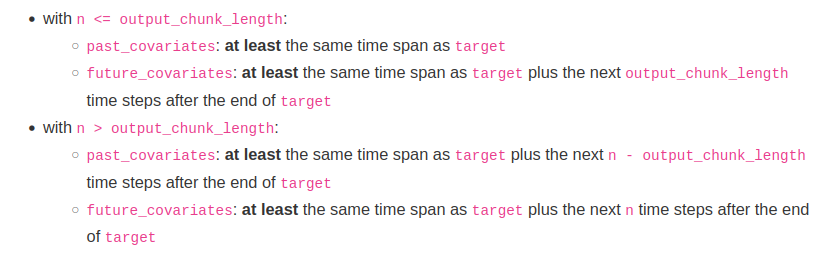

### Declare model

In [8]:
class LossLogger(Callback):
    def __init__(self):
        self.train_loss = []
        self.val_loss = []

    # will automatically be called at the end of each epoch
    def on_train_epoch_end(
        self, trainer: "pl.Trainer", pl_module: "pl.LightningModule"
    ) -> None:
        self.train_loss.append(float(trainer.callback_metrics["train_loss"]))

    def on_validation_epoch_end(
        self, trainer: "pl.Trainer", pl_module: "pl.LightningModule"
    ) -> None:
        self.val_loss.append(float(trainer.callback_metrics["val_loss"]))


loss_logger = LossLogger()


# early stop callback
my_stopper = EarlyStopping(
    monitor="val_loss",  # "val_MeanAbsolutePercentageError"
    patience=5,
    min_delta=5e-3,
    mode="min",
)

pl_trainer_kwargs = {
    "accelerator": "gpu",
    "devices": [0],
    "callbacks": [my_stopper, loss_logger],
}
# default quantiles for QuantileRegression
# quantiles = [0.01, 0.05, 0.10, 0.20, 0.40, 0.50, 0.60, 0.80, 0.90, 0.95, 0.99]

my_model = TFTModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=output_chunk_length,
    hidden_size=256,
    lstm_layers=1,
    num_attention_heads=4,
    dropout=0.42,
    batch_size=128,
    n_epochs=20,
    use_static_covariates=True,
    add_relative_index=False,
    add_encoders=None,
    # QuantileRegression is set per default
    # likelihood=QuantileRegression(
    #     quantiles=quantiles),
    likelihood=None,
    loss_fn=torch.nn.MSELoss(),
    optimizer_cls=torch.optim.Adam,
    optimizer_kwargs={"lr": 1e-3},
    lr_scheduler_cls=torch.optim.lr_scheduler.StepLR,
    lr_scheduler_kwargs={"step_size": 6, "gamma": 1e-1},
    random_state=42,
    model_name="q_mm_day_hs256_bs128_do042",
    # model_name="test_tft",
    work_dir="./model",
    save_checkpoints=True,
    force_reset=False,
)

In [9]:
my_model.fit(
    series=train_target,
    past_covariates=past_cov,
    future_covariates=future_cov,
    val_series=val_target,
    val_past_covariates=val_past_cov,
    val_future_covariates=val_future_cov,
    verbose=True,
)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [58]:
some_shit_pred = my_model.predict(
    series=val_target,
    past_covariates=pred_cov,
    future_covariates=pred_cov,
    n=600,
    num_samples=1,
)

Predicting: |          | 0/? [00:00<?, ?it/s]

<AxesSubplot:xlabel='date'>

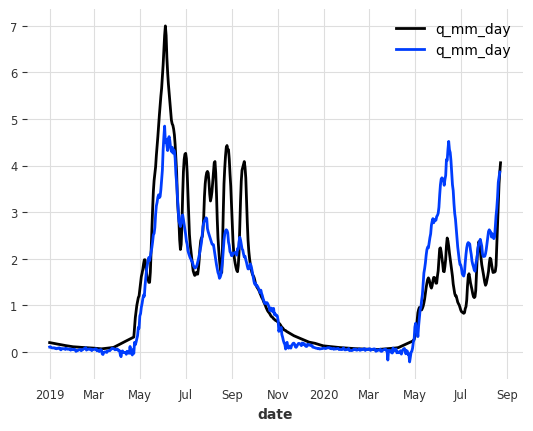

In [60]:
train_target_scaler.inverse_transform(
    pred_target[0][
        pd.to_datetime("2019-01-01") : pd.to_datetime("2019-01-01")
        + pd.to_timedelta("600D")
    ]
).plot()
train_target_scaler.inverse_transform(some_shit_pred[0]).plot()

In [14]:
def nse(predictions, targets):
    return 1 - (
        np.nansum((targets - predictions) ** 2)
        / np.nansum((targets - np.nanmean(targets)) ** 2)
    )

In [20]:
some_gauge_shit = my_model.historical_forecasts(
    num_samples=1,
    series=train_target_scale,
    past_covariates=train_cov_scale,
    future_covariates=pred_cov_scale,
    retrain=False,
    verbose=True,
)

Predicting: |          | 0/? [00:00<?, ?it/s]

In [12]:
ws_file.index

Index(['9002', '9022', '9053', '9112', '9115', '9116', '9122', '9124', '9125',
       '9127',
       ...
       '10387', '11350', '12129', '11048', '11619', '11056', '11061', '11801',
       '10031', '2027'],
      dtype='object', name='gauge_id', length=2080)

In [25]:
_file["q_mm_day"][~_file["q_mm_day"].isna()]

184     1.819382
185     1.723359
186     1.723359
187     1.693036
188     1.624809
          ...   
5048    2.259066
5049    2.102397
5050    2.061966
5051    2.195893
5052    2.271701
Name: q_mm_day, Length: 630, dtype: float64

In [38]:
_file = pd.read_csv(f"../ais_parsers/ais_results_2021/75201.csv")
_file["q_cms_s"].values[:100]

array([1.90e-01, 1.70e-01, 1.50e-01, 1.30e-01, 1.20e-01, 1.10e-01,
       8.80e+01, 8.30e+01, 7.70e+01, 6.50e-02, 6.50e-02, 6.90e+01,
       7.50e+01, 7.80e+01, 8.40e+01, 9.00e-02, 9.60e+01, 1.10e-01,
       1.10e-01, 1.20e-01, 1.20e-01, 1.30e-01, 1.20e-01, 1.30e-01,
       1.20e-01, 1.30e-01, 1.30e-01, 1.30e-01, 1.30e-01, 1.30e-01,
       1.30e-01, 1.40e-01, 1.40e-01, 1.40e-01, 1.40e-01, 1.30e-01,
       1.30e-01, 1.20e-01, 1.20e-01, 1.30e-01, 1.40e-01, 1.50e-01,
       2.00e-01, 2.20e-01, 2.10e-01, 2.10e-01, 2.10e-01, 2.00e-01,
       2.00e-01, 1.90e-01, 1.90e-01, 1.90e-01, 1.80e-01, 1.70e-01,
       1.60e-01, 1.60e-01, 1.60e-01, 1.60e-01, 1.60e-01, 1.60e-01,
       1.80e-01, 2.00e-01, 2.30e-01, 2.40e-01, 2.50e-01, 2.60e-01,
       2.70e-01, 2.70e-01, 2.70e-01, 2.80e-01, 3.10e-01, 3.20e-01,
       3.60e-01, 4.20e-01, 4.70e-01, 5.20e-01, 5.20e-01, 4.80e-01,
       4.70e-01, 4.70e-01, 4.50e-01, 4.30e-01, 4.10e-01, 4.10e-01,
       4.40e-01, 5.10e-01, 6.30e-01, 6.70e-01, 6.80e-01, 6.80e

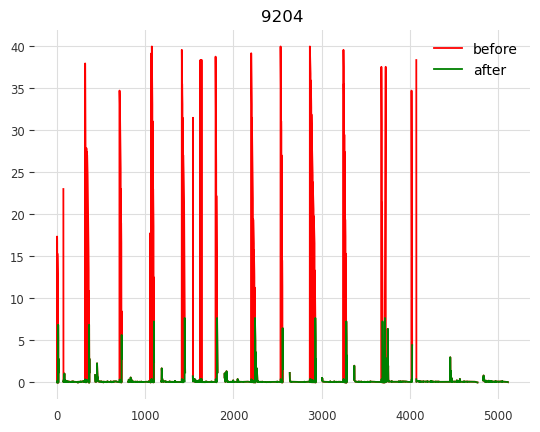

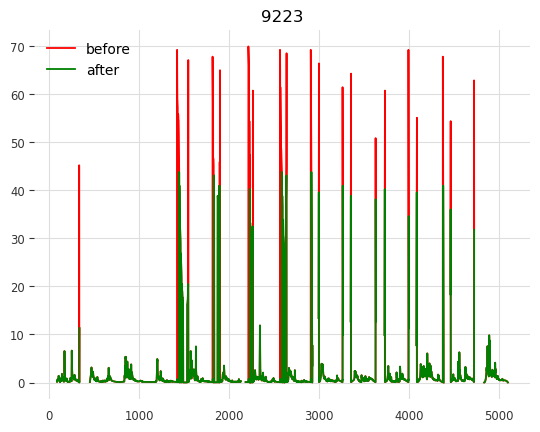

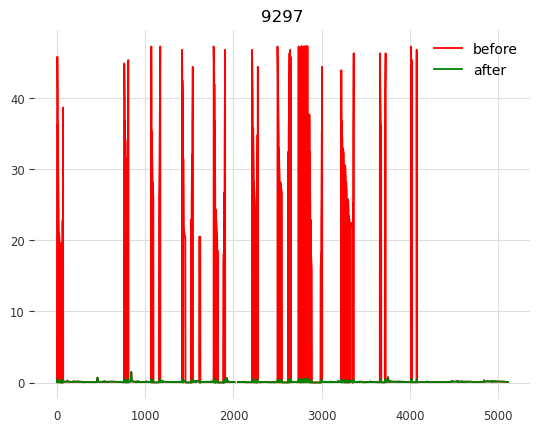

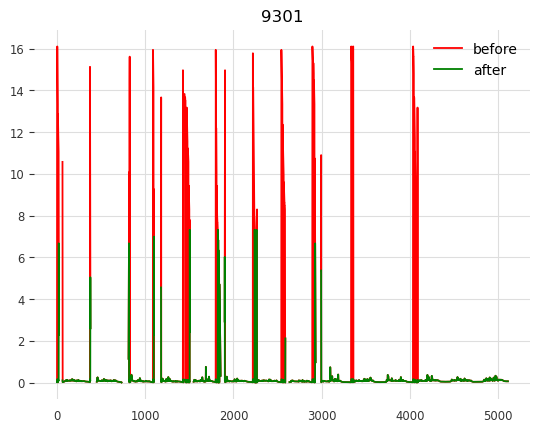

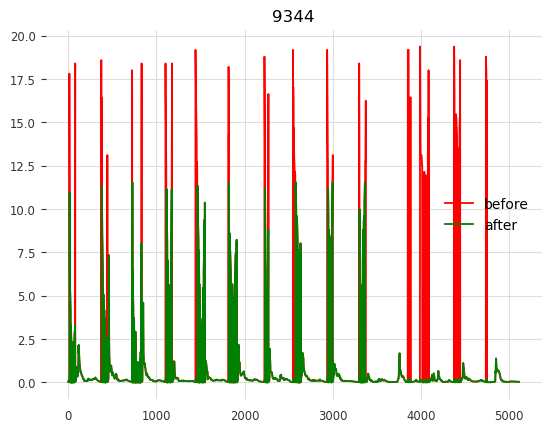

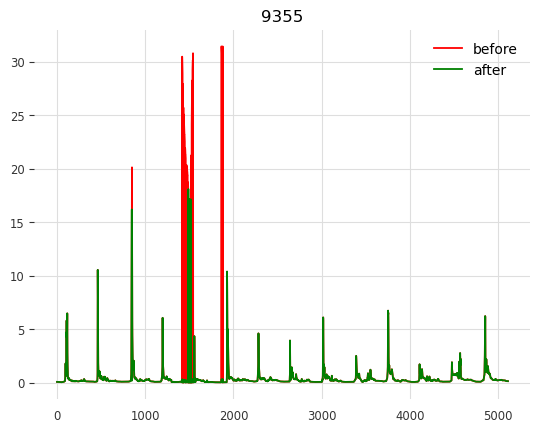

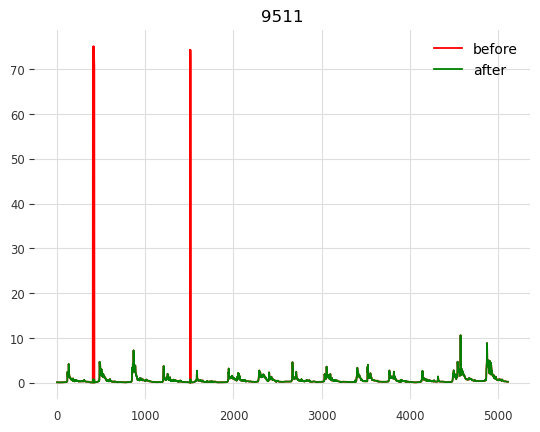

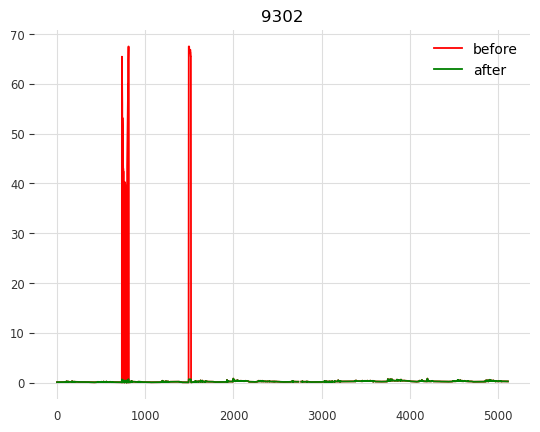

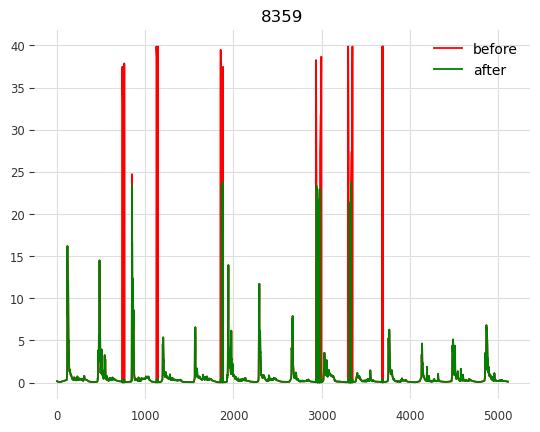

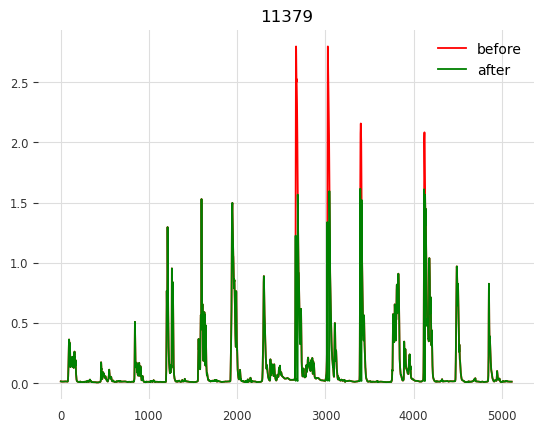

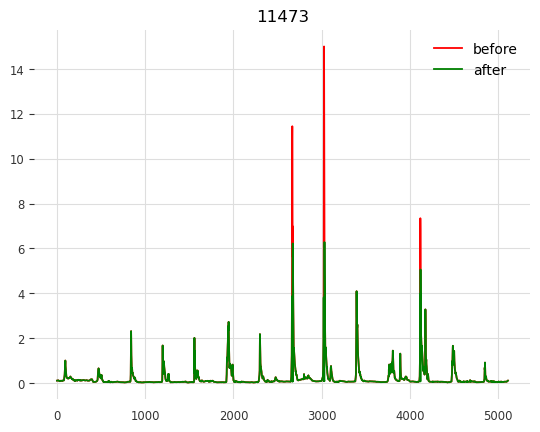

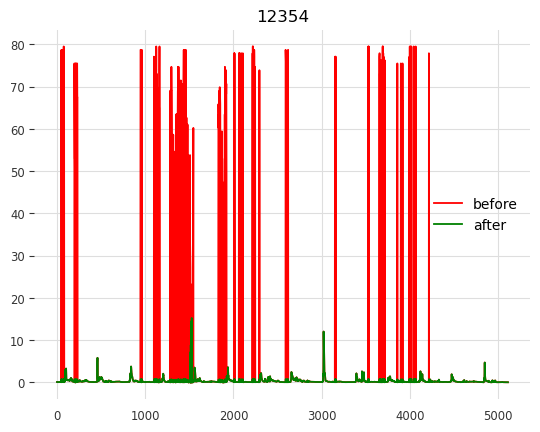

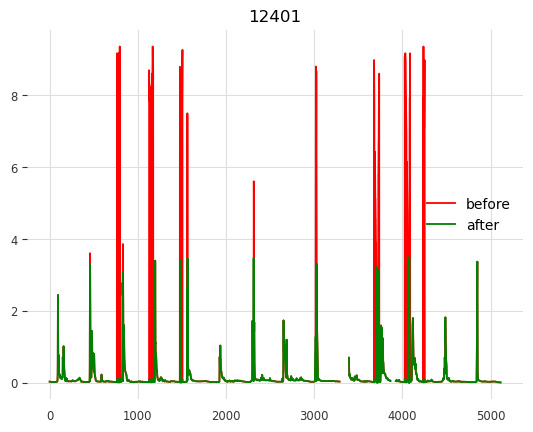

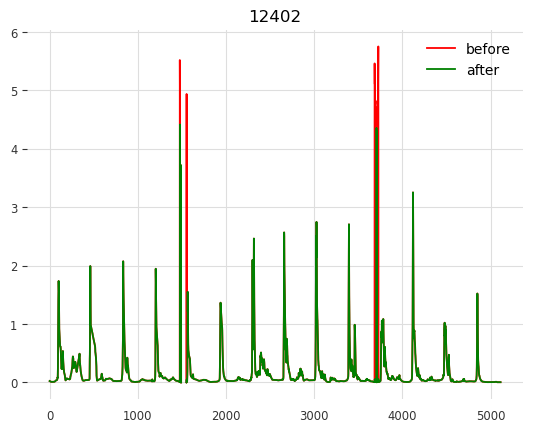

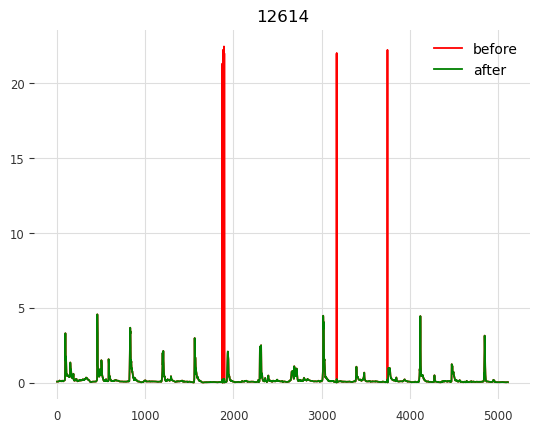

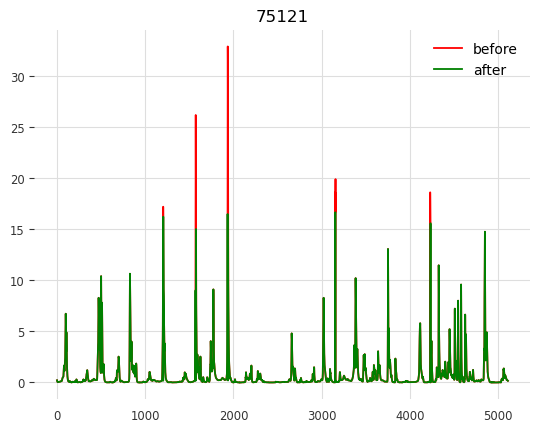

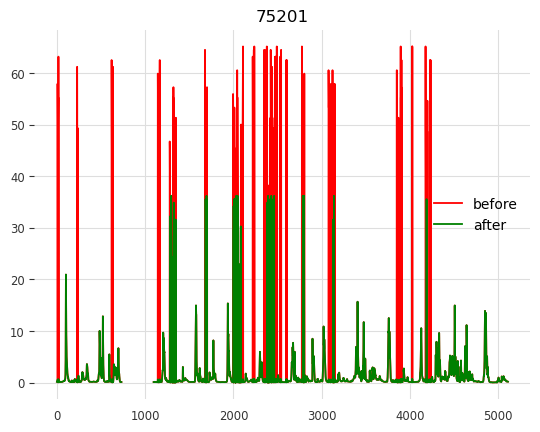

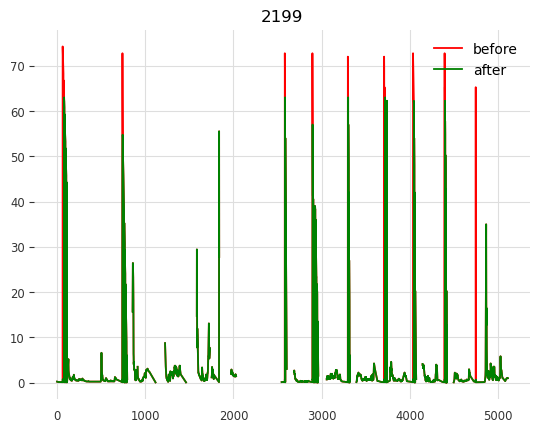

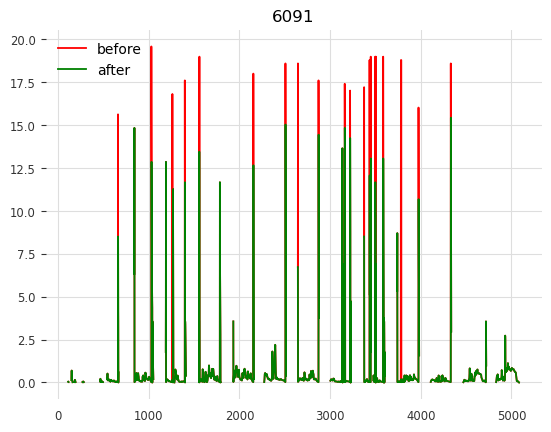

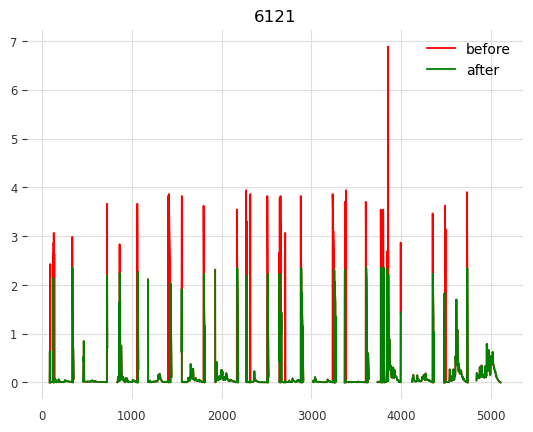

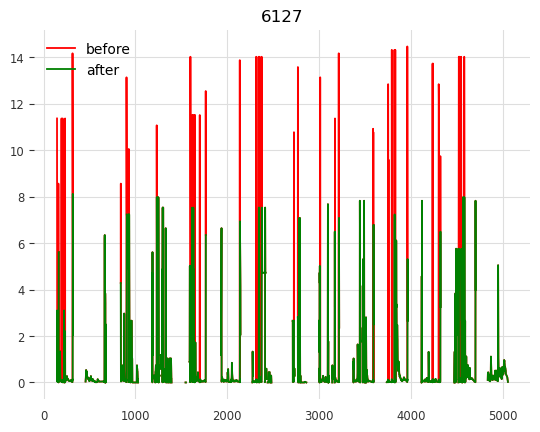

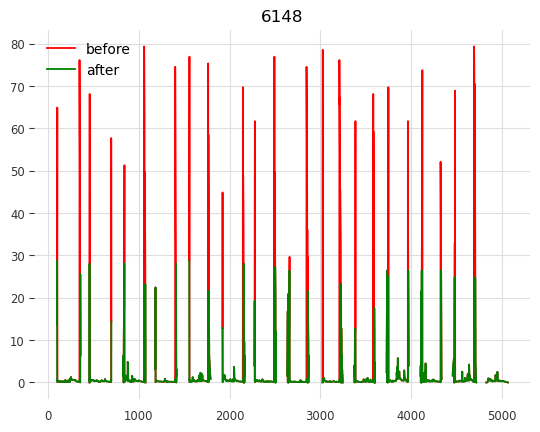

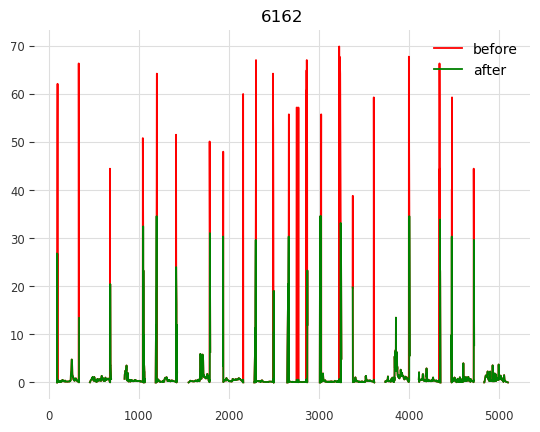

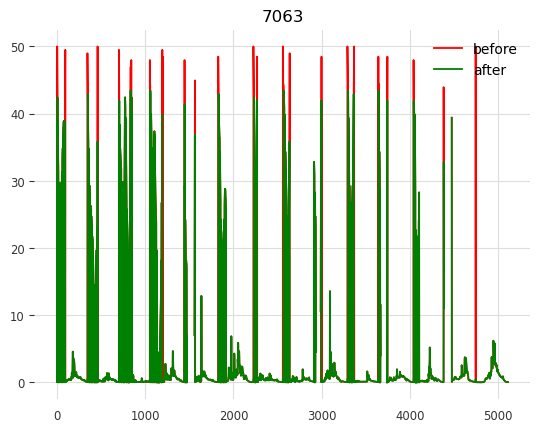

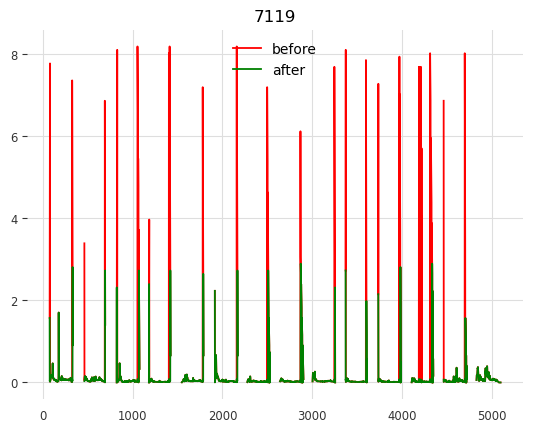

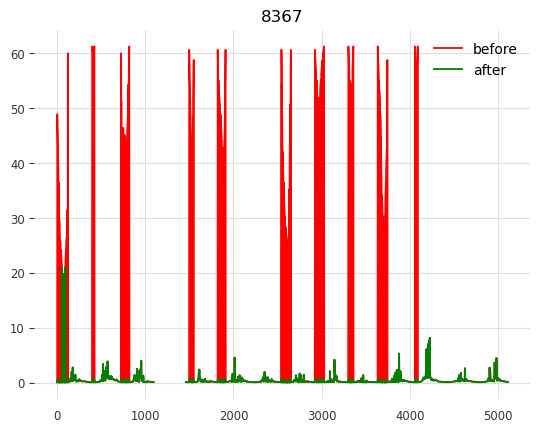

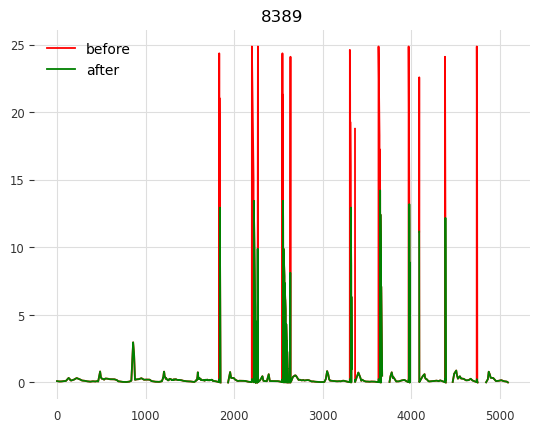

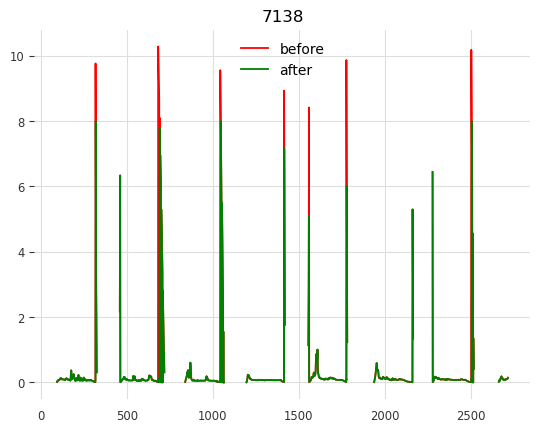

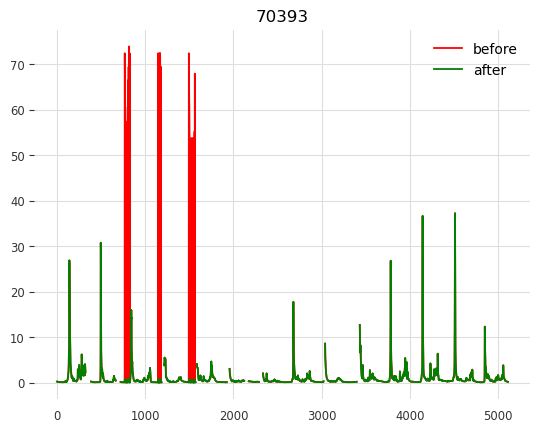

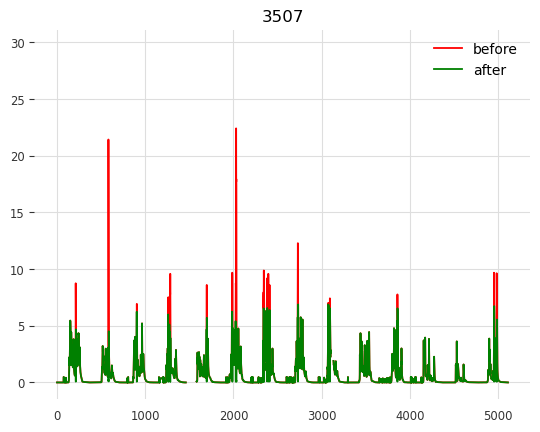

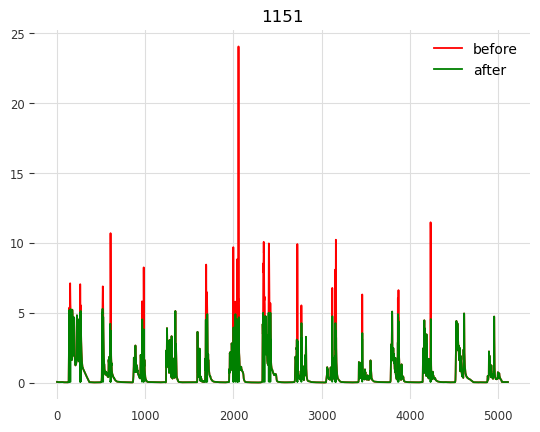

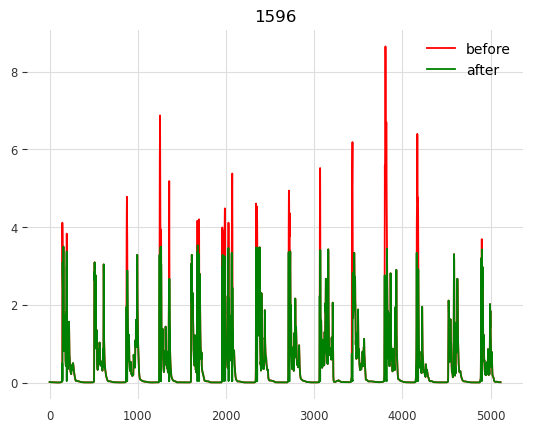

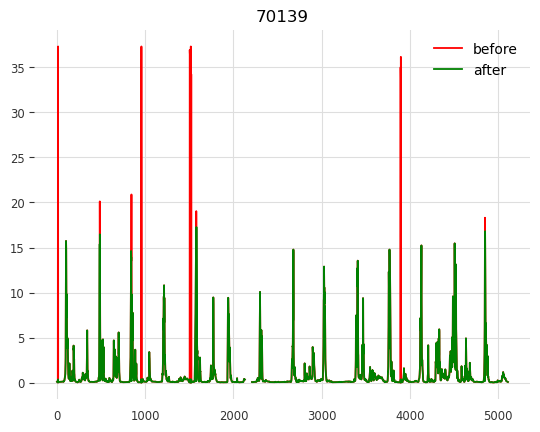

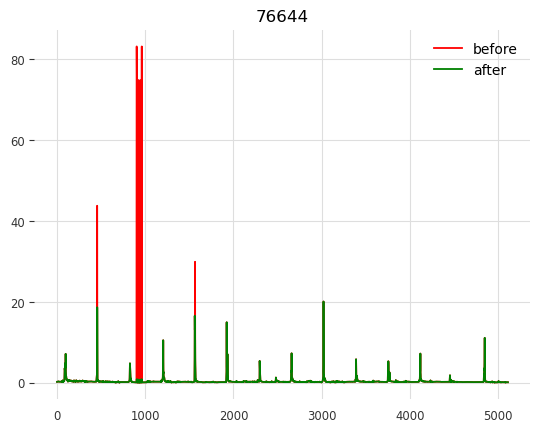

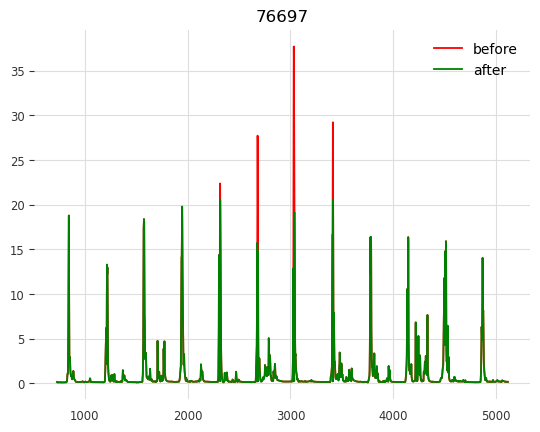

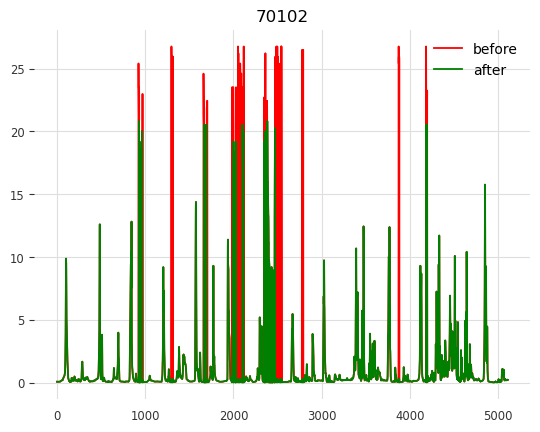

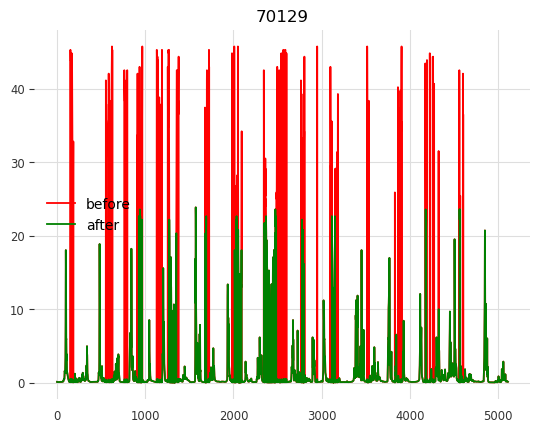

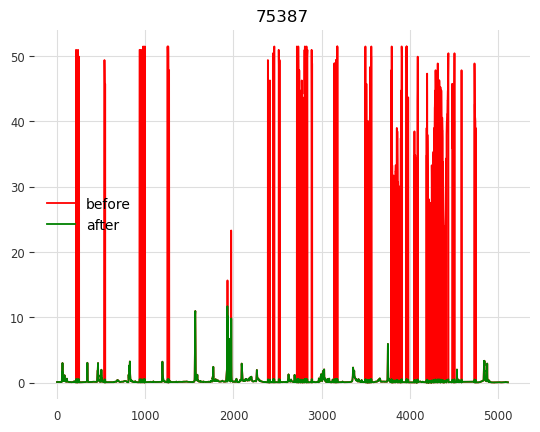

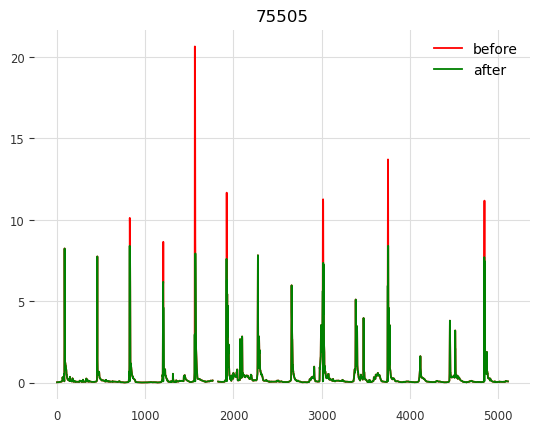

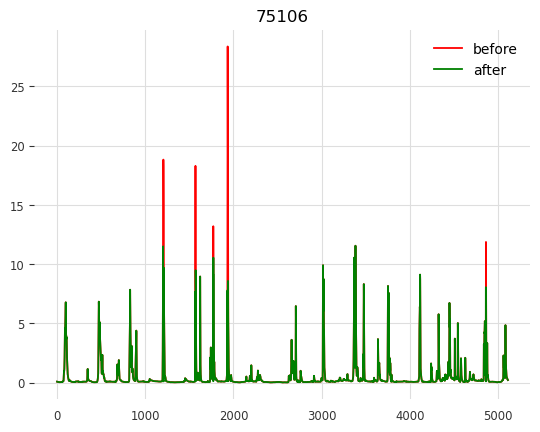

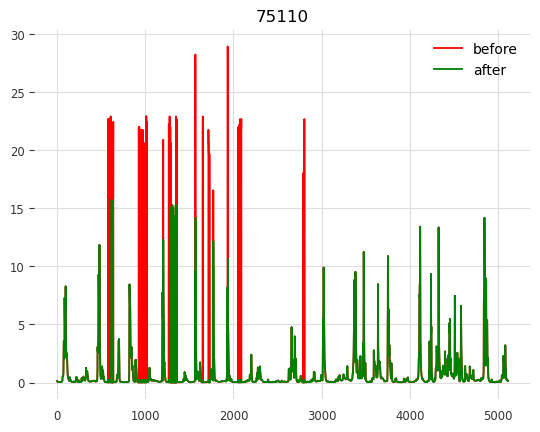

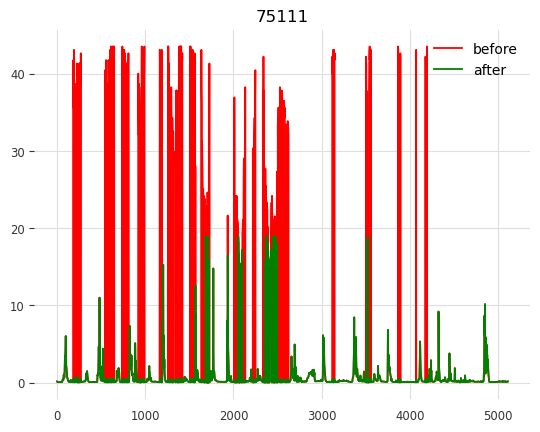

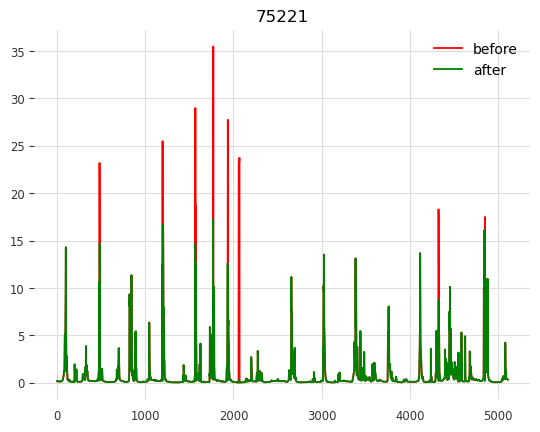

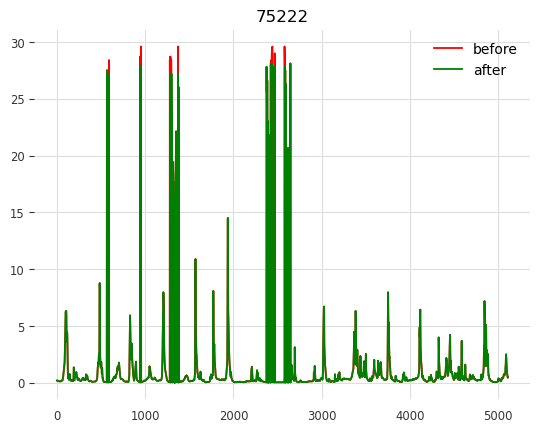

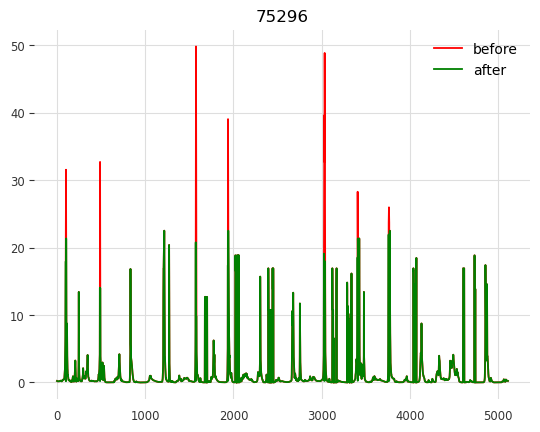

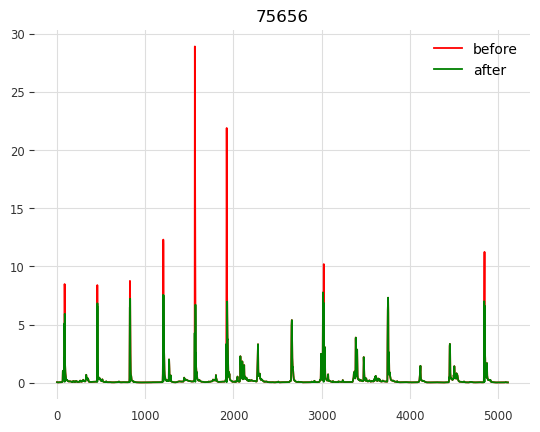

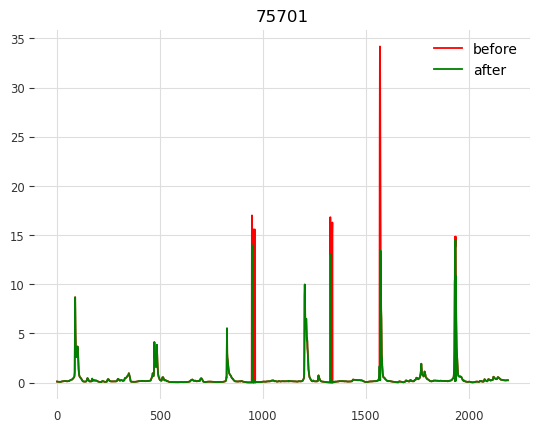

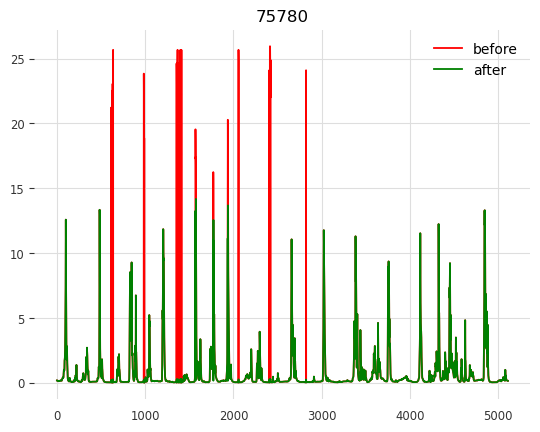

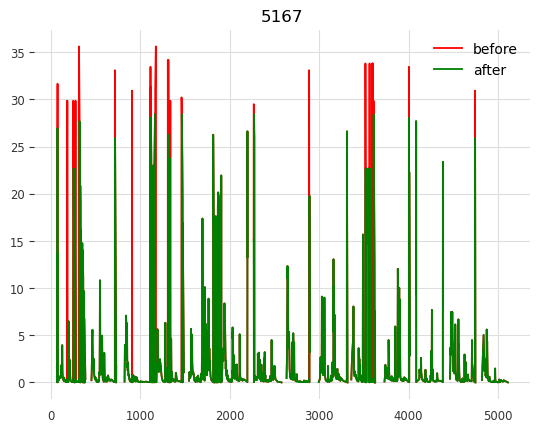

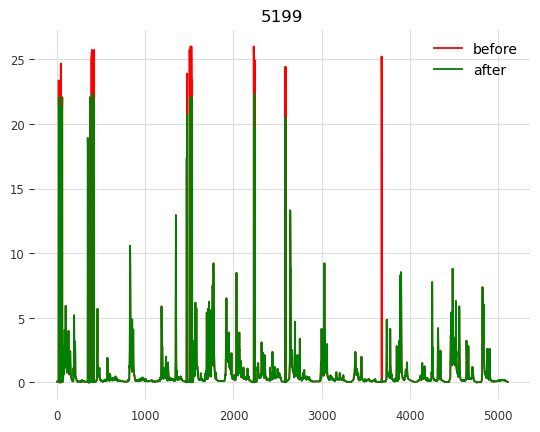

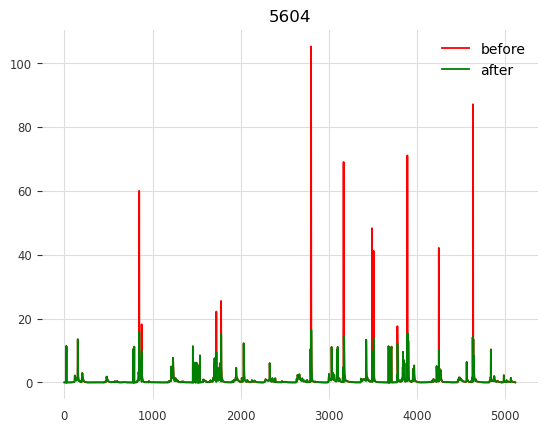

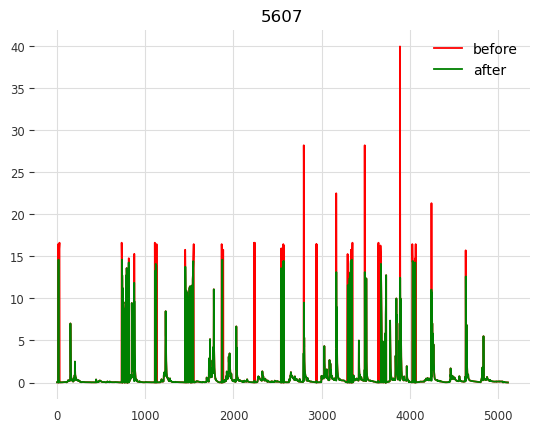

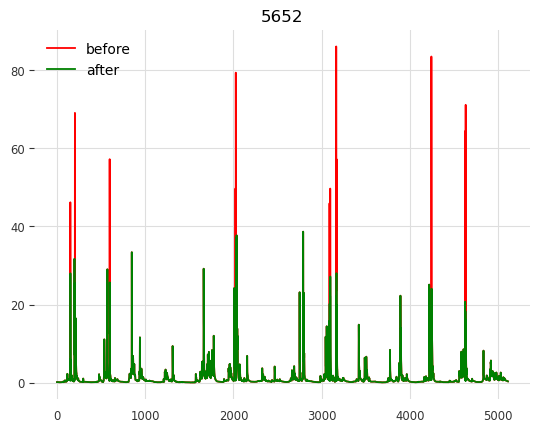

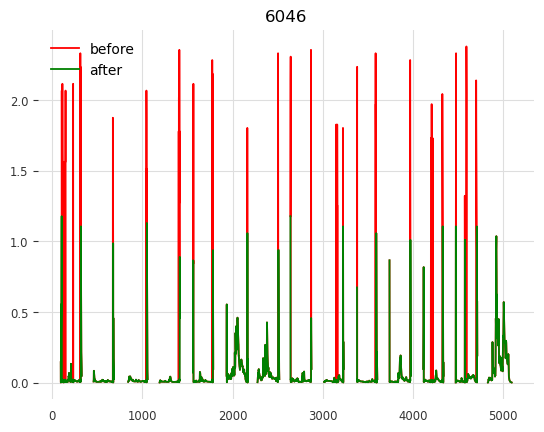

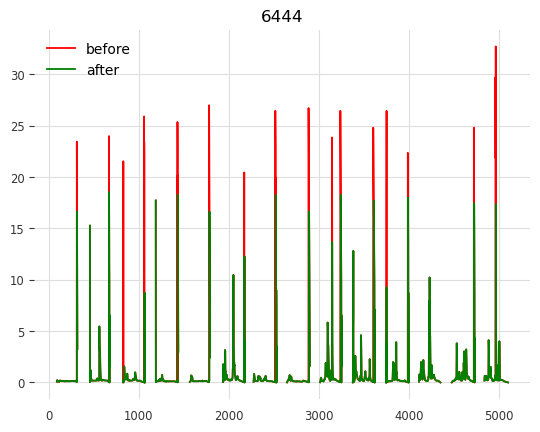

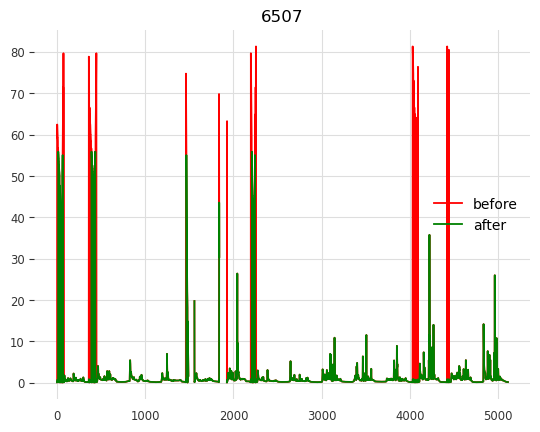

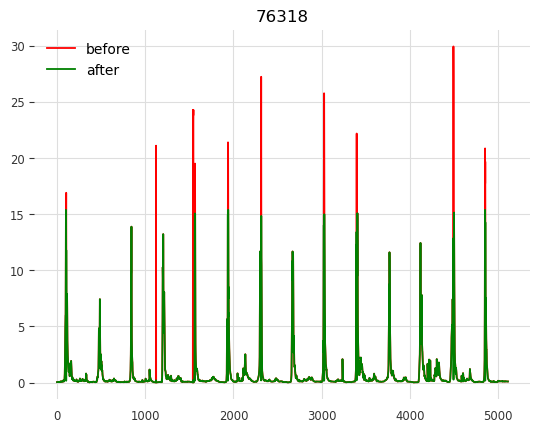

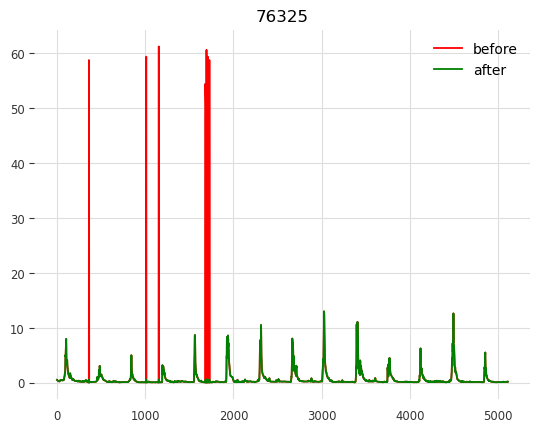

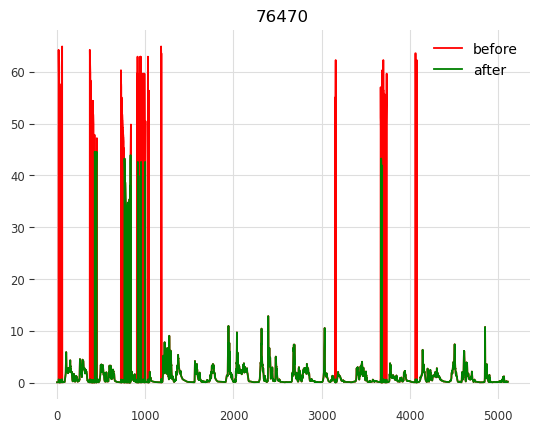

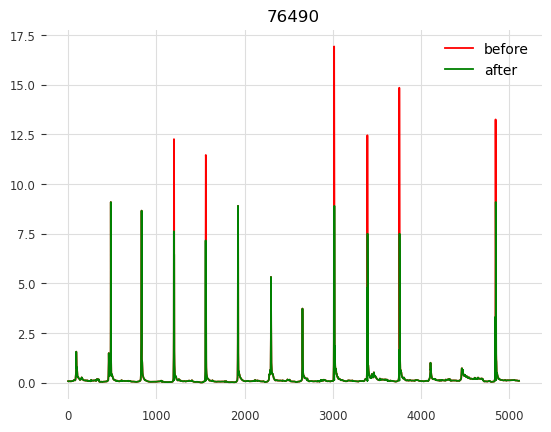

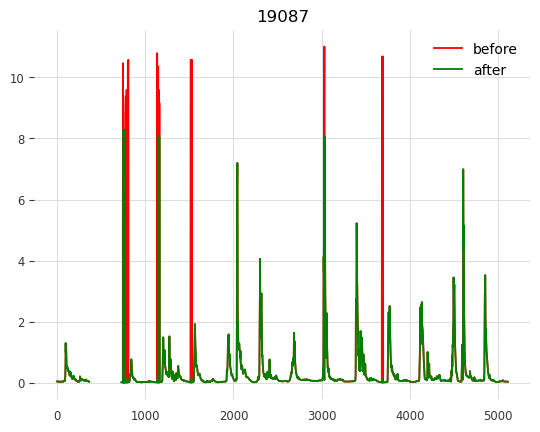

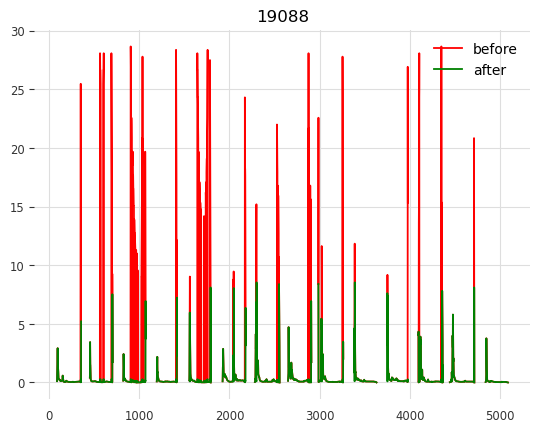

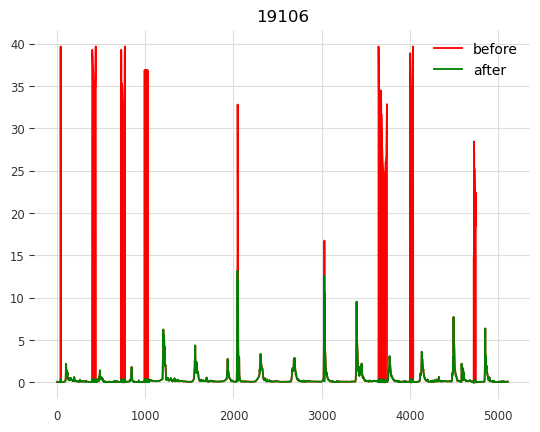

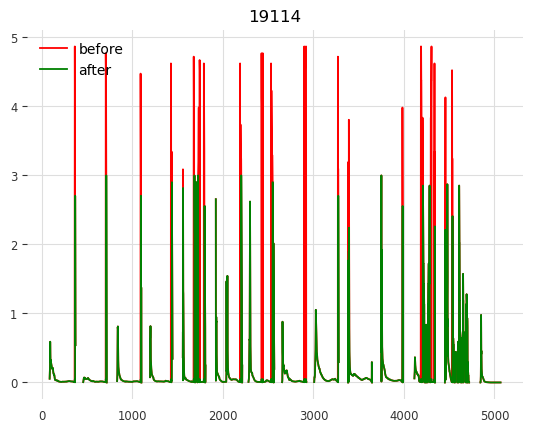

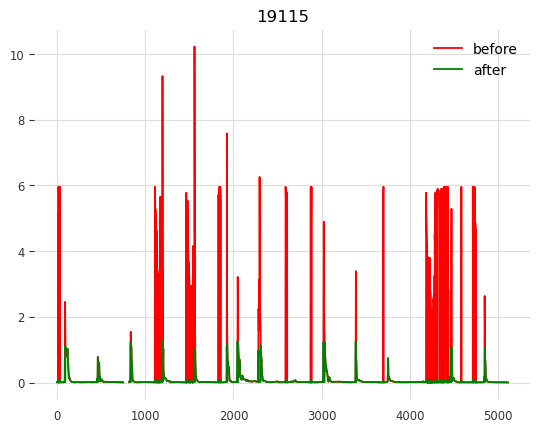

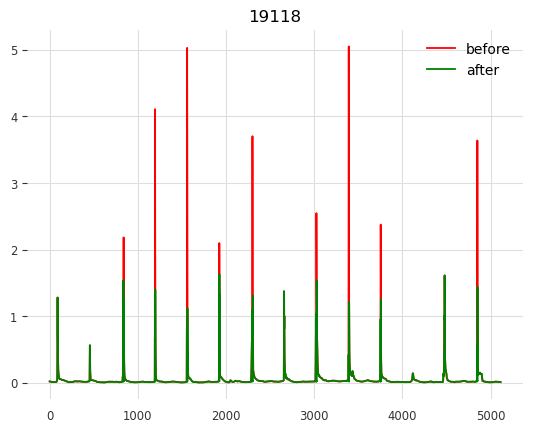

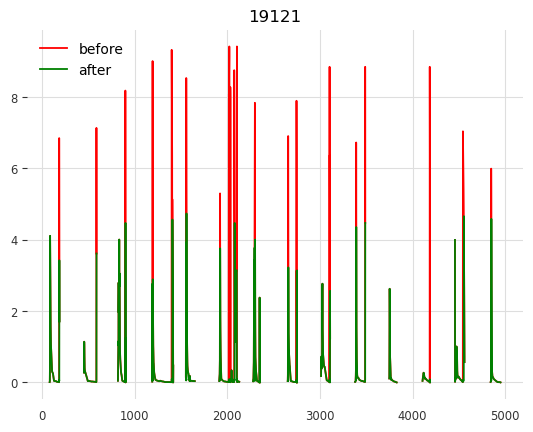

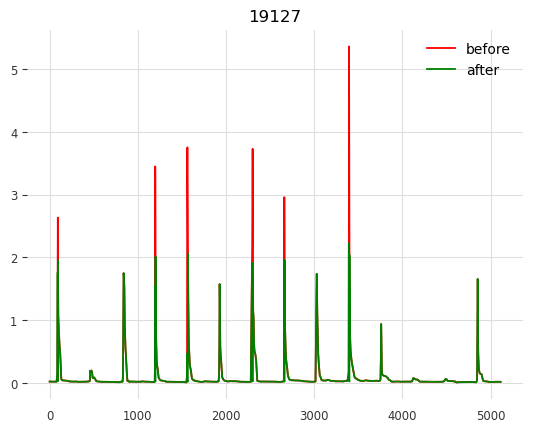

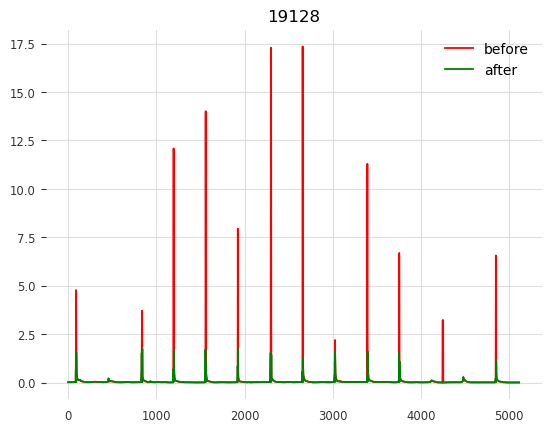

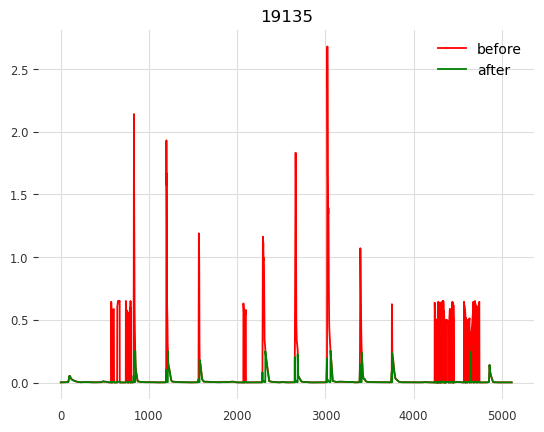

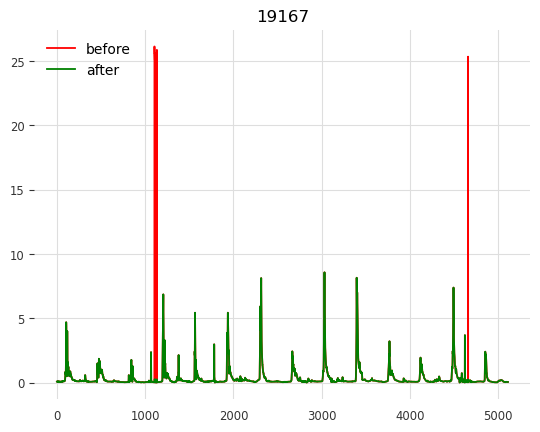

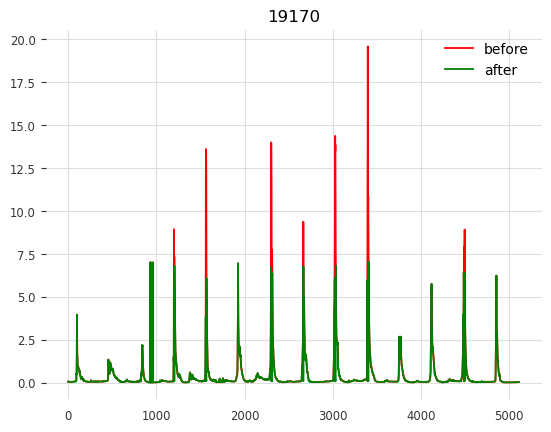

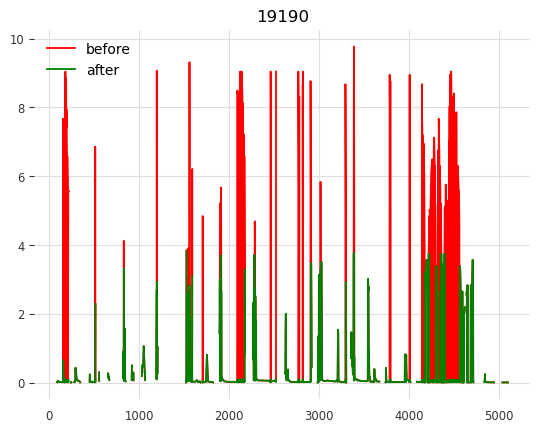

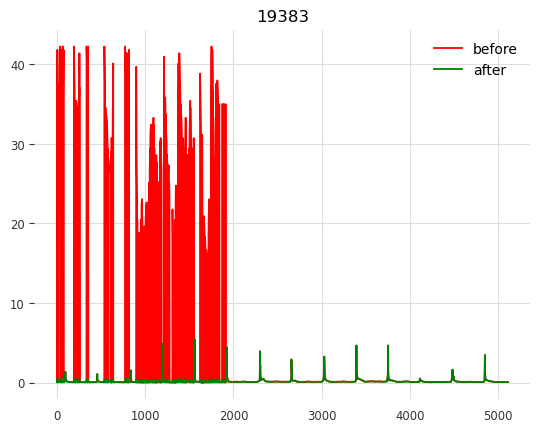

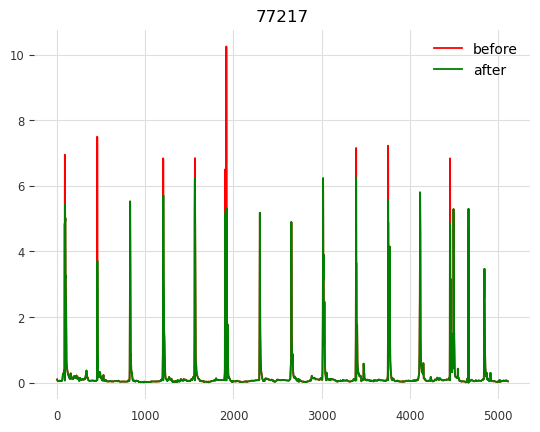

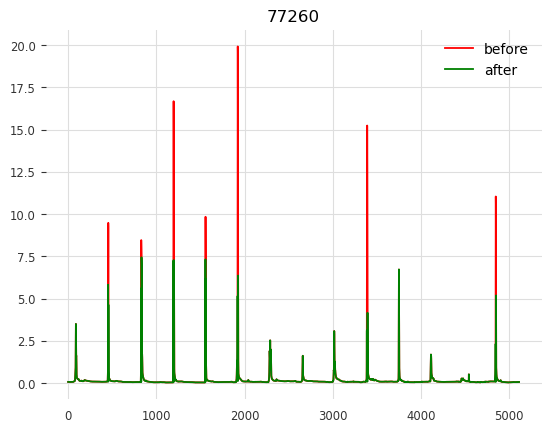

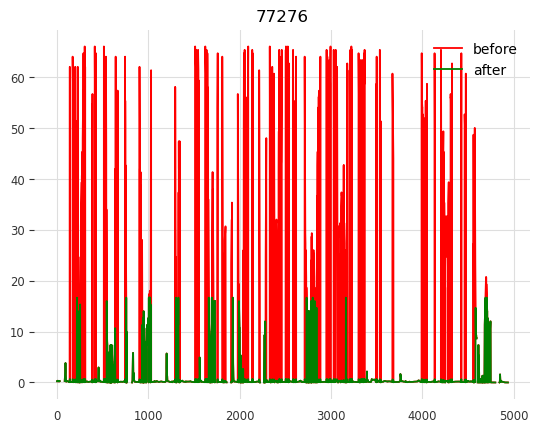

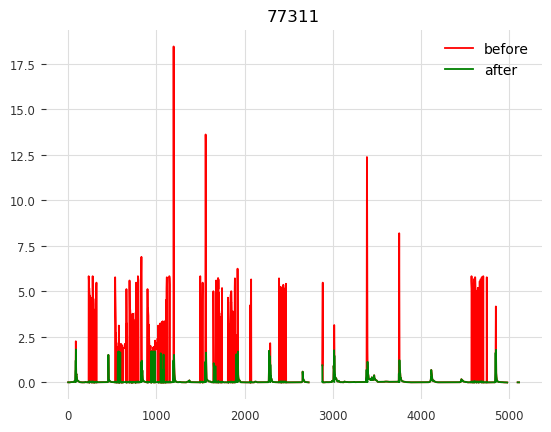

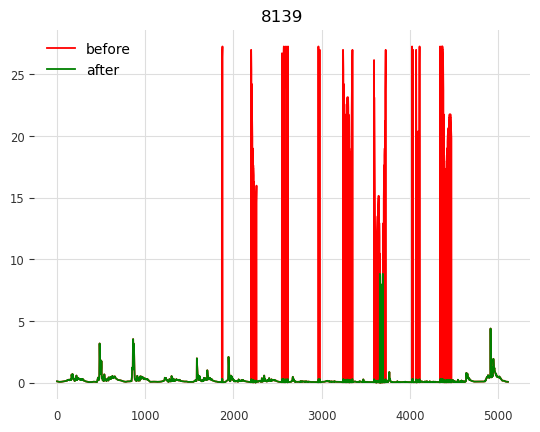

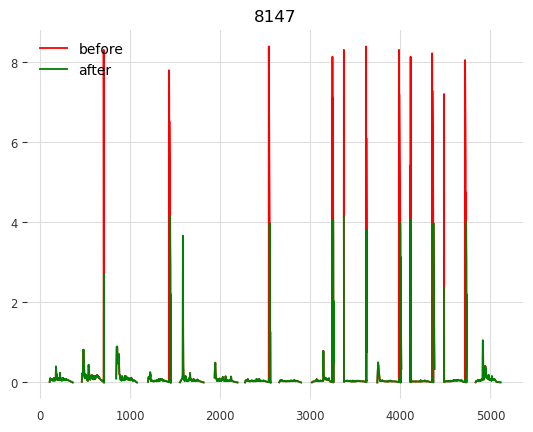

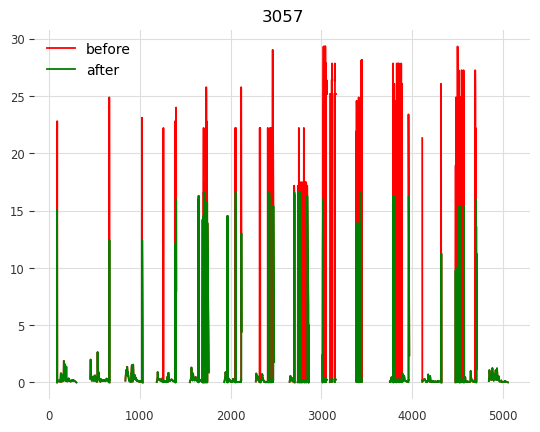

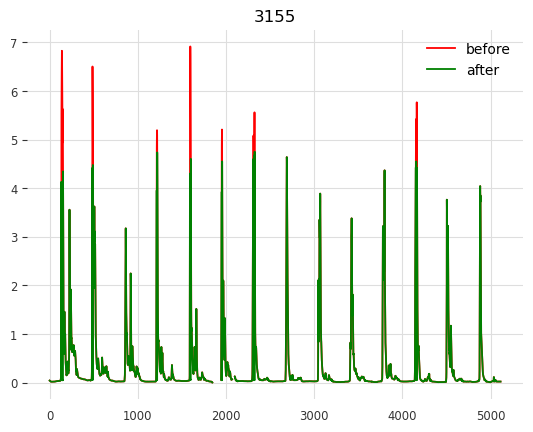

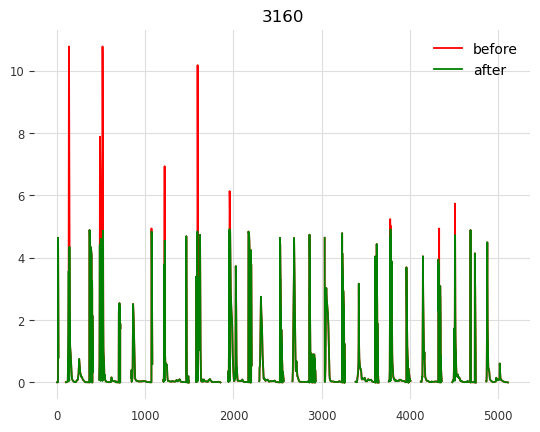

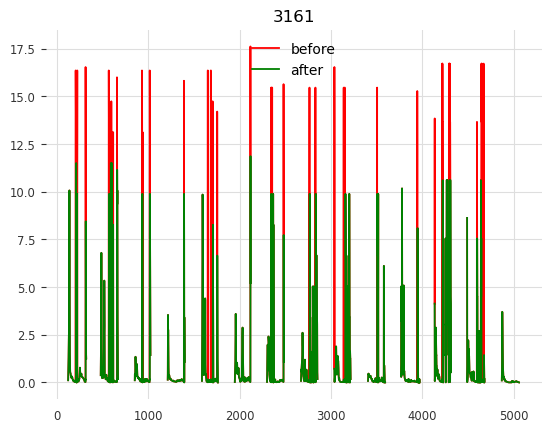

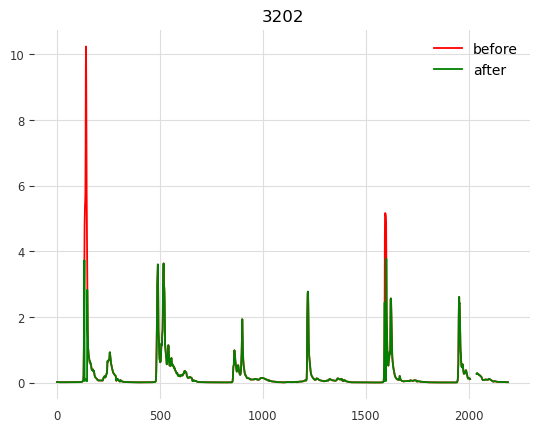

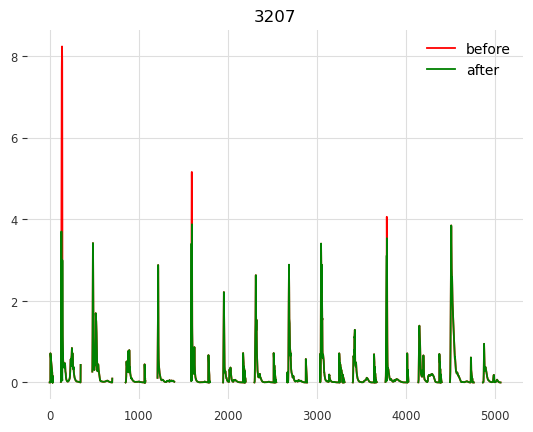

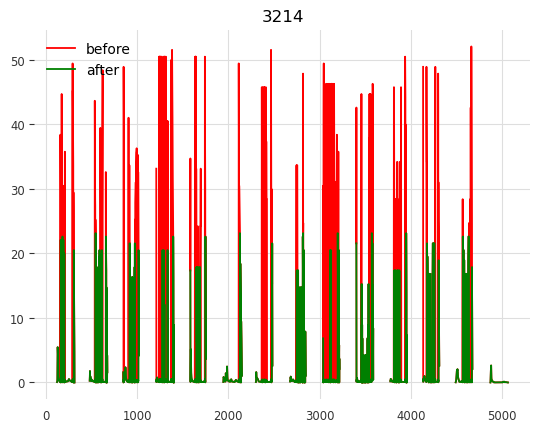

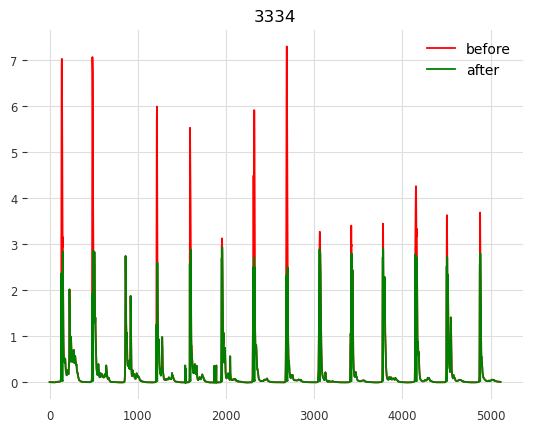

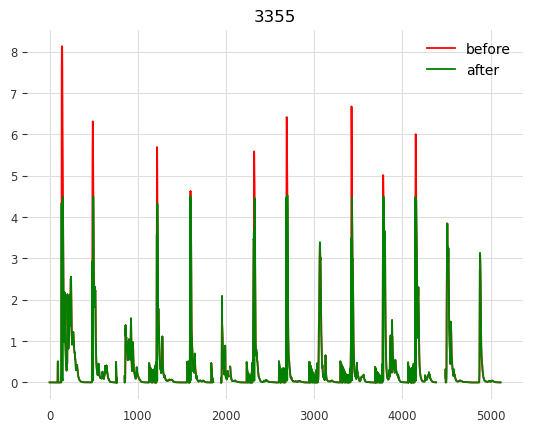

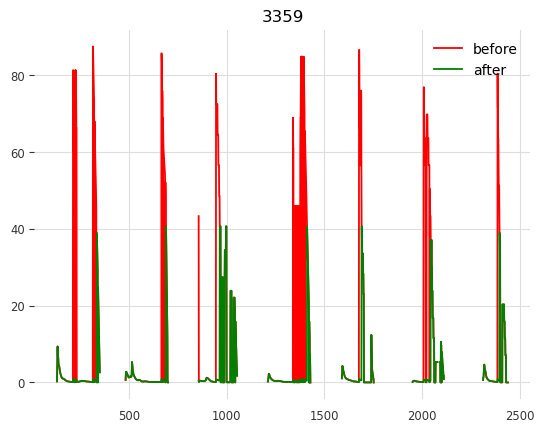

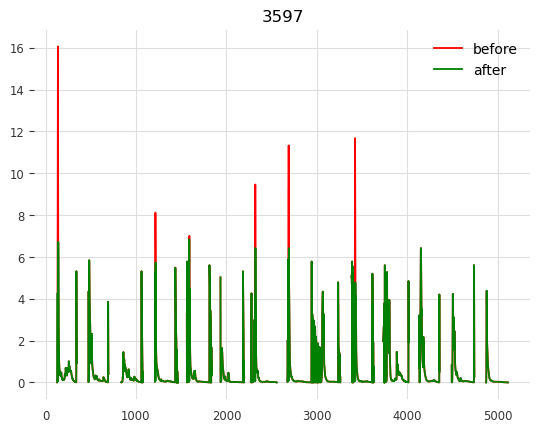

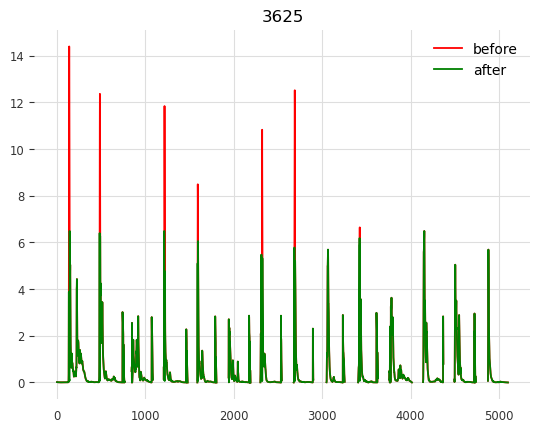

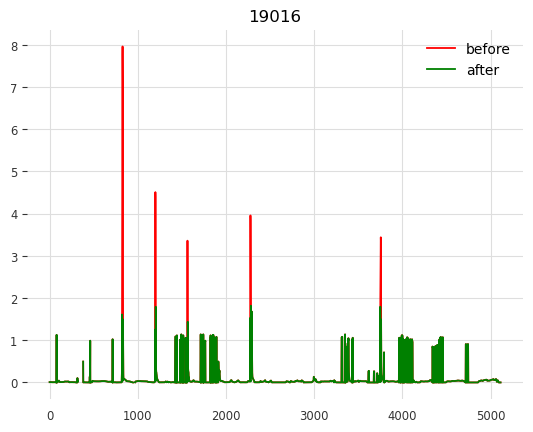

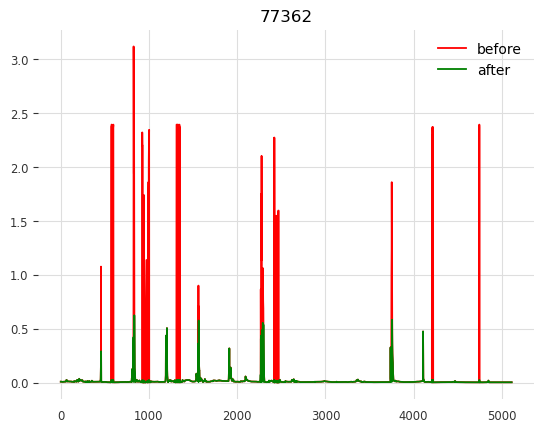

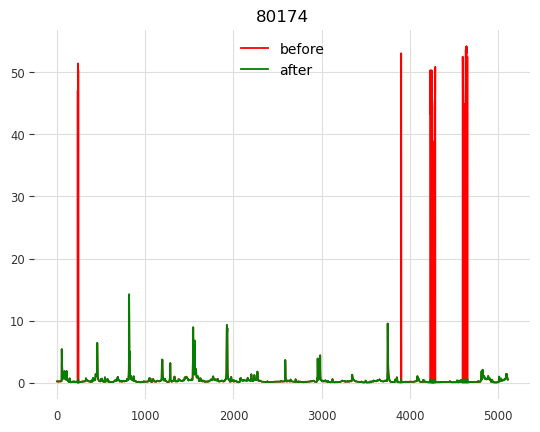

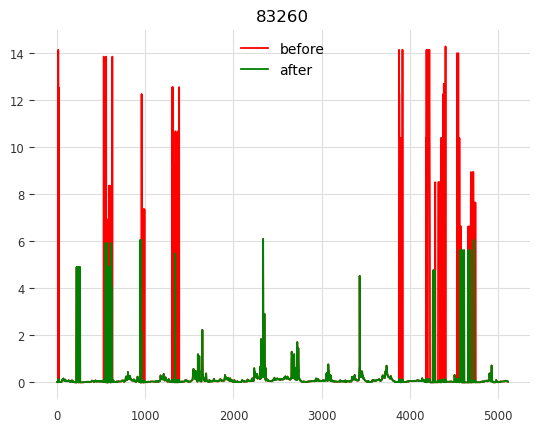

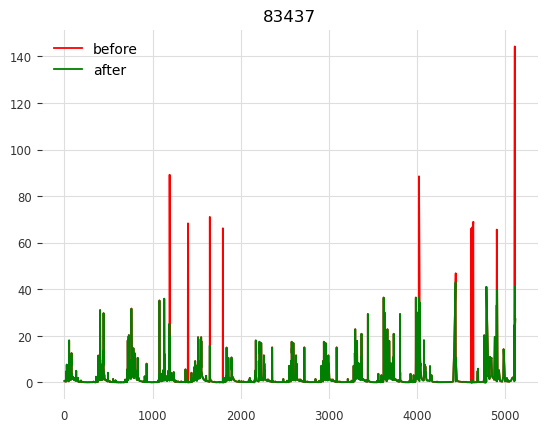

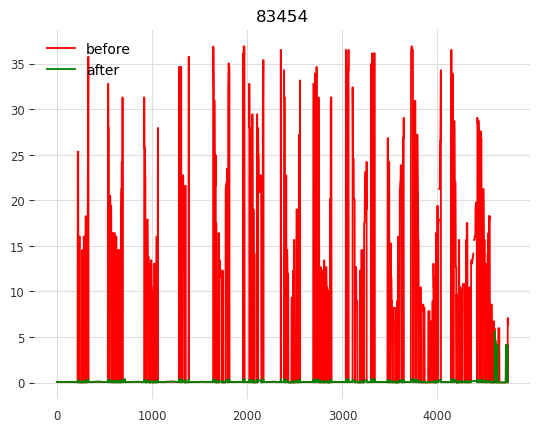

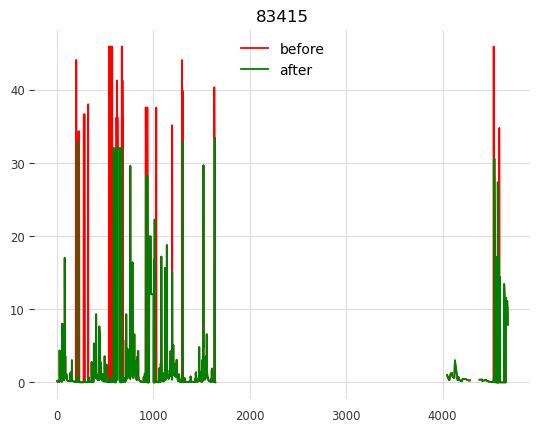

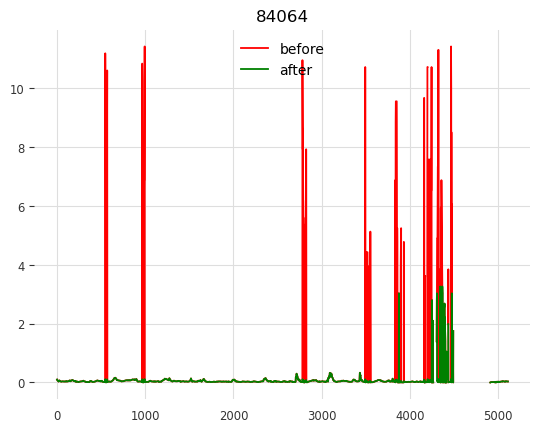

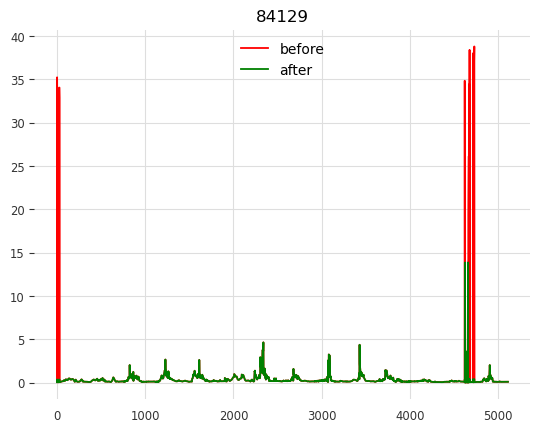

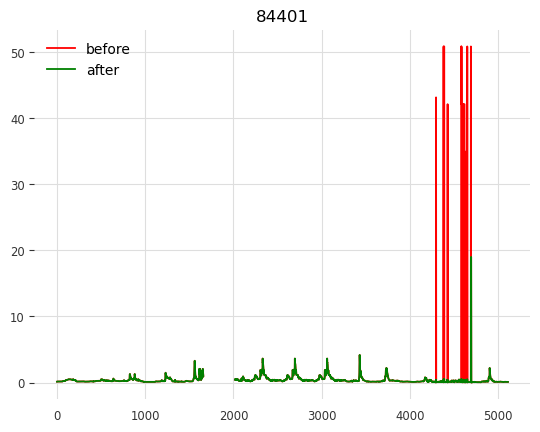

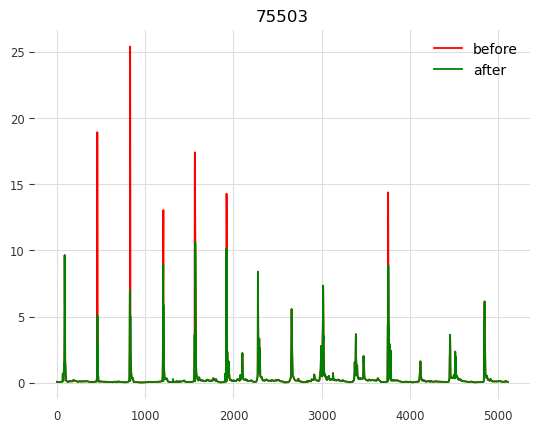

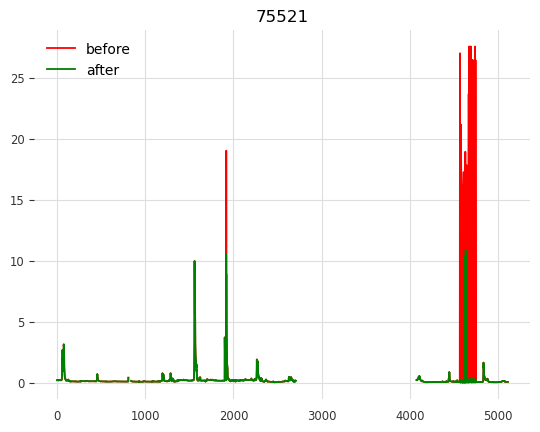

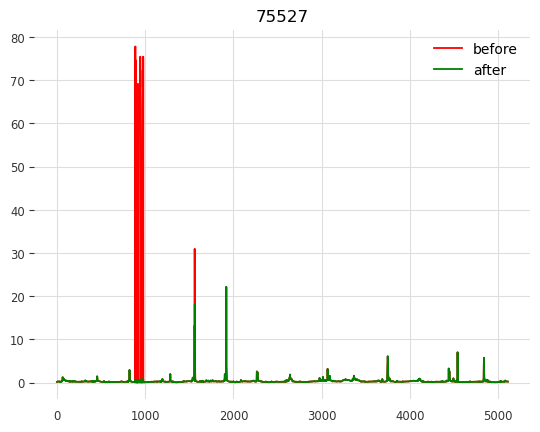

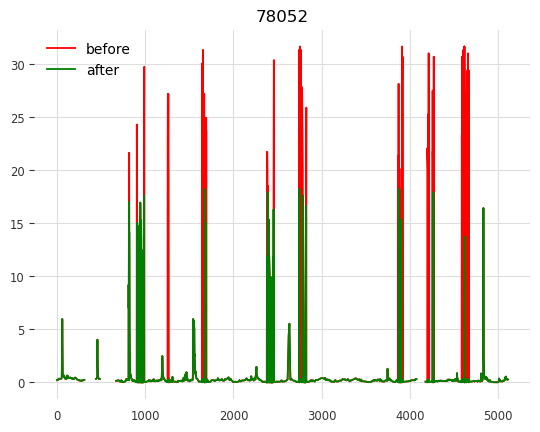

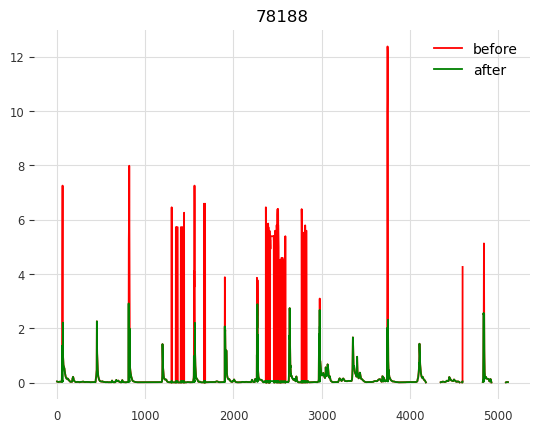

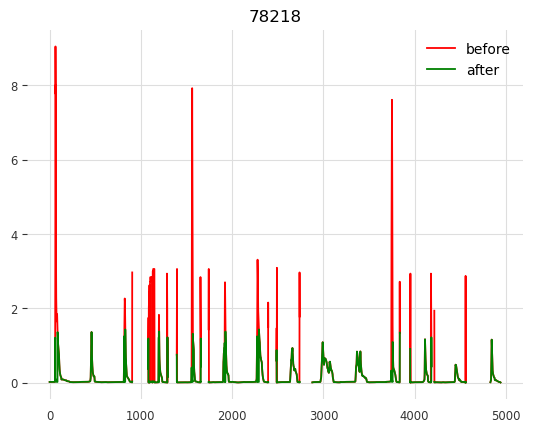

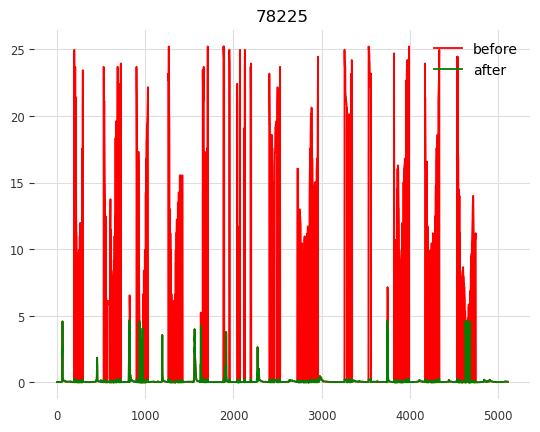

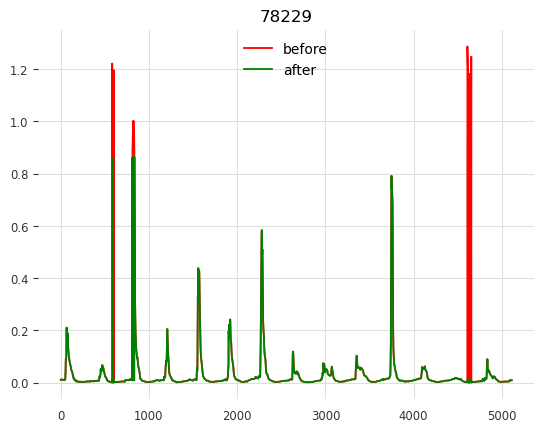

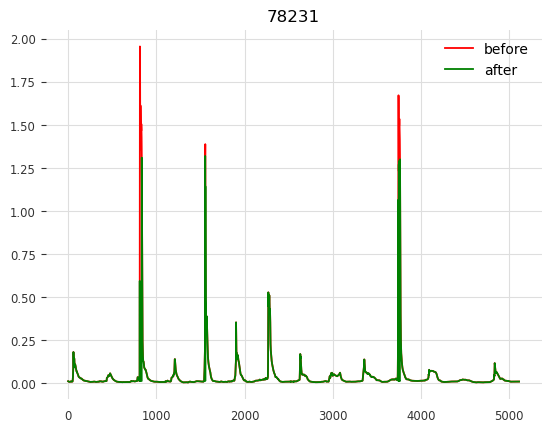

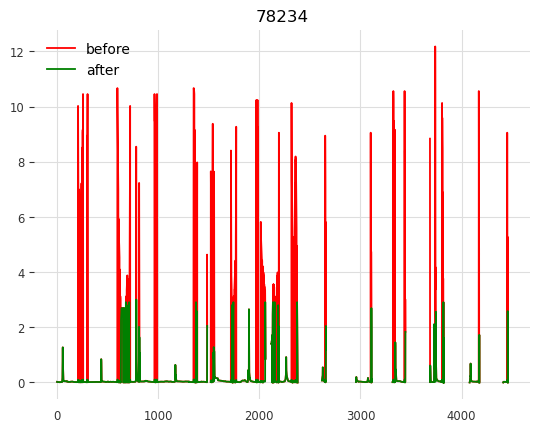

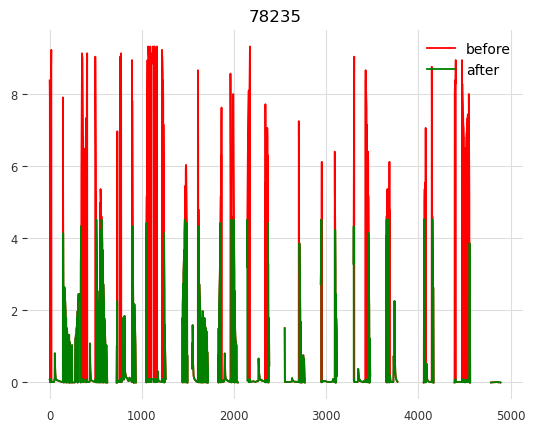

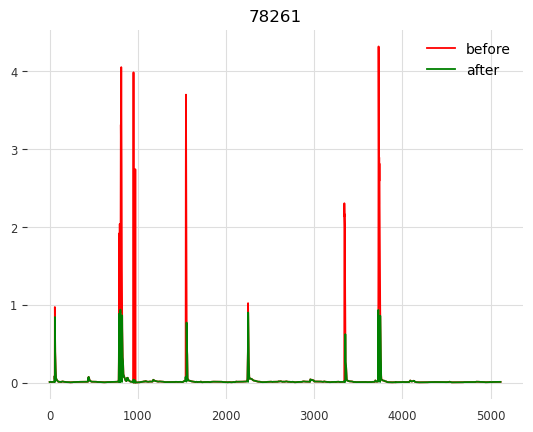

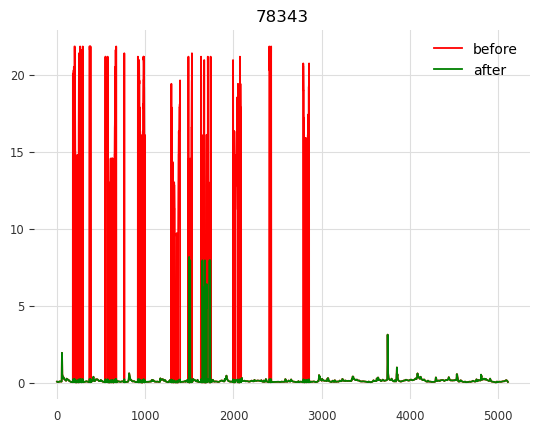

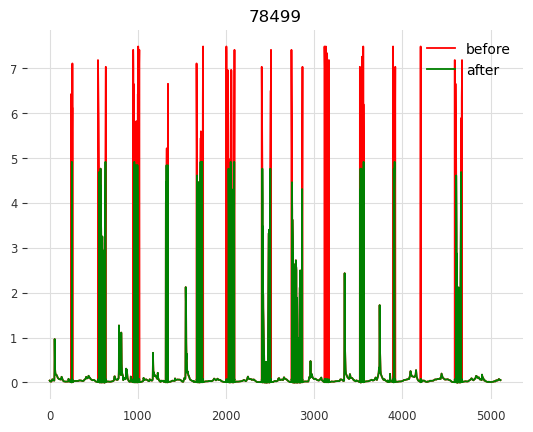

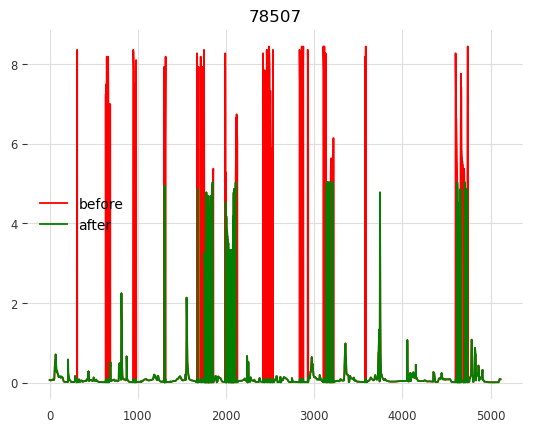

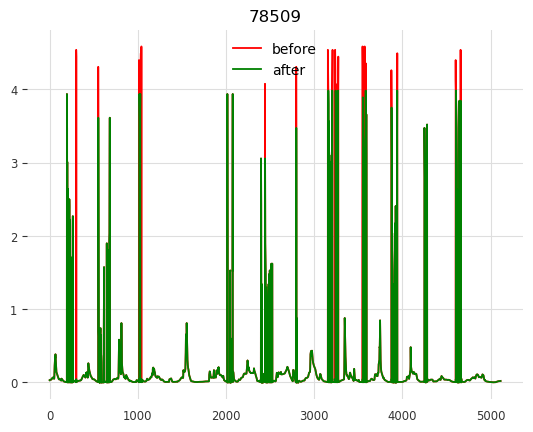

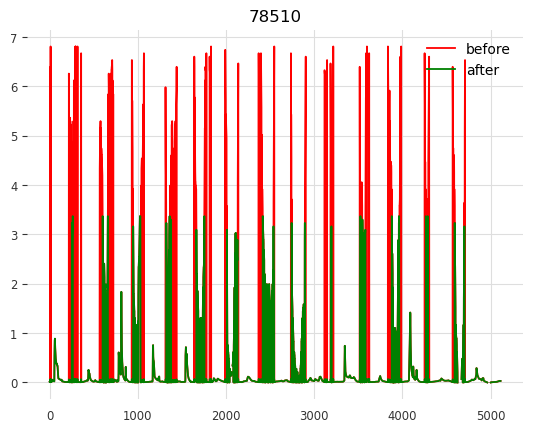

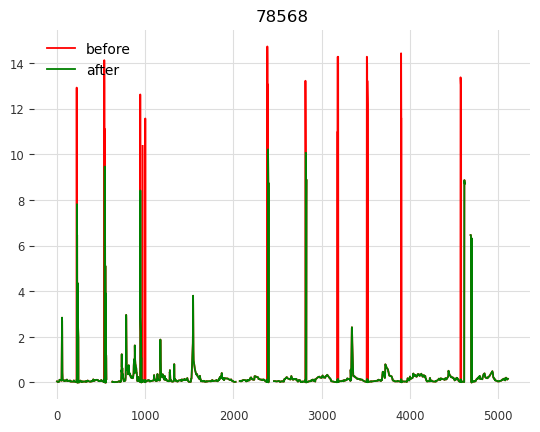

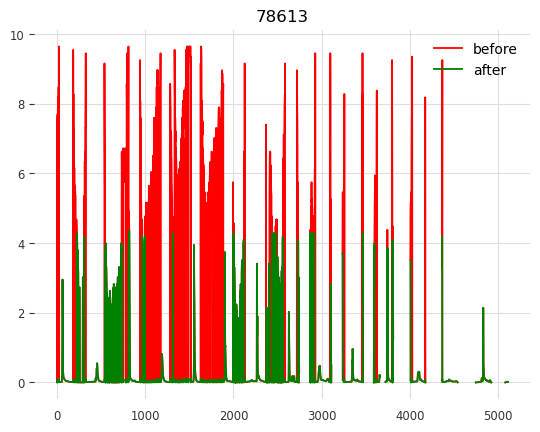

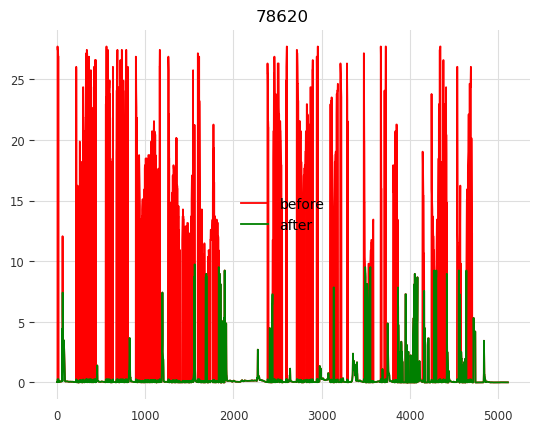

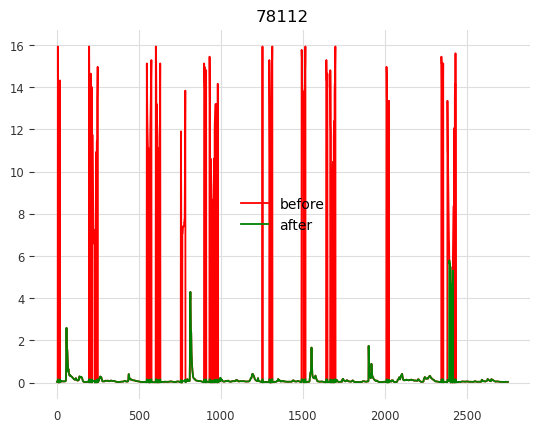

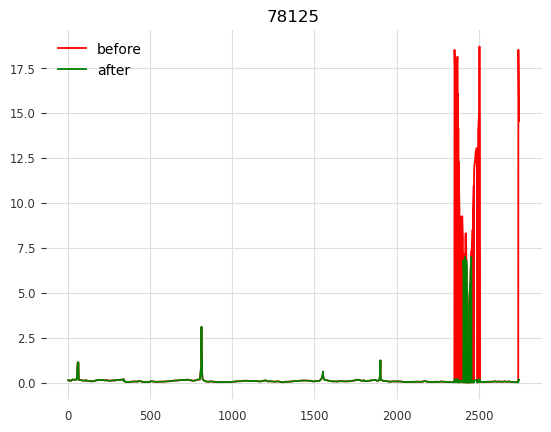

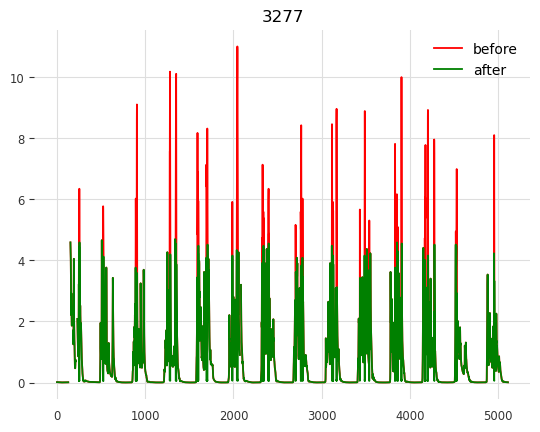

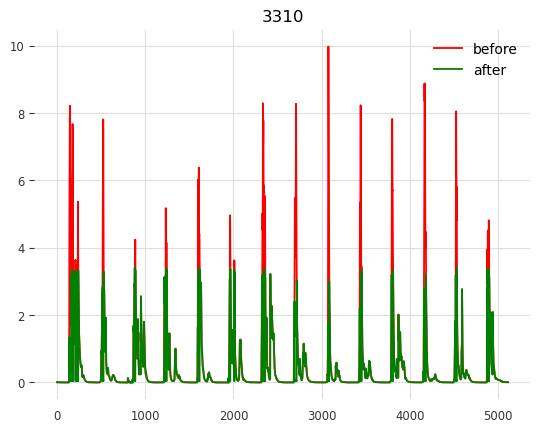

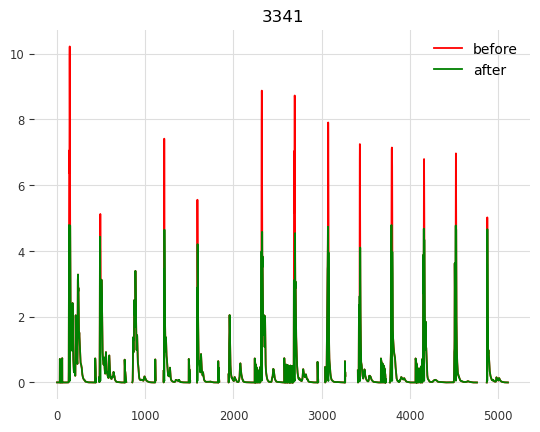

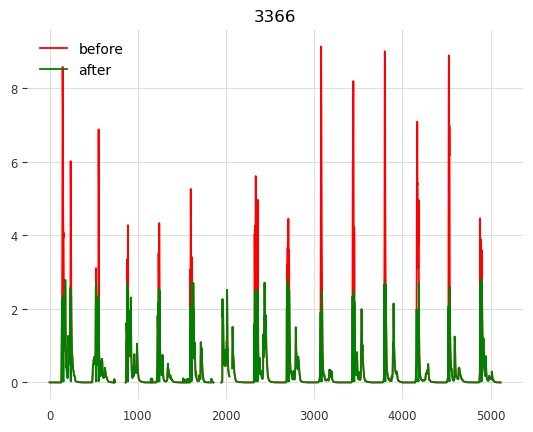

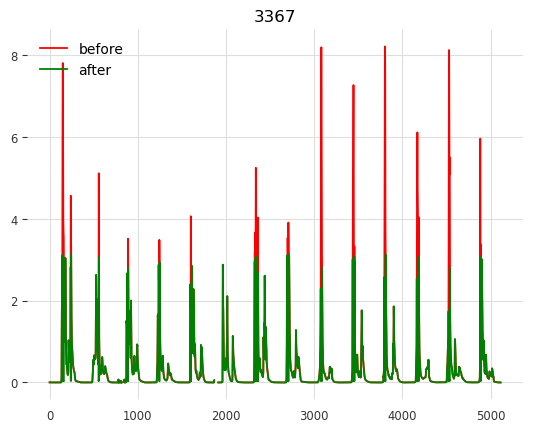

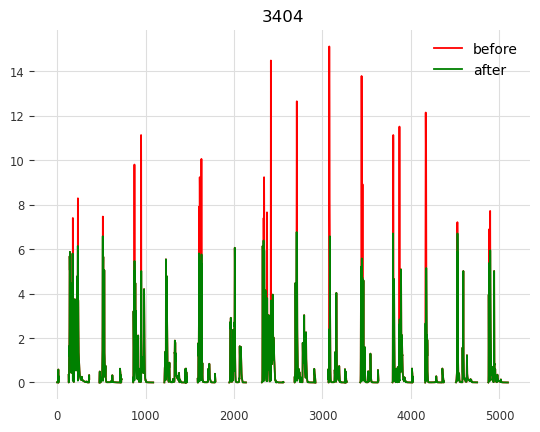

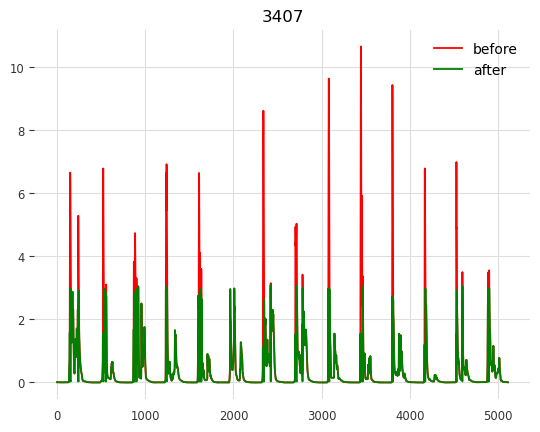

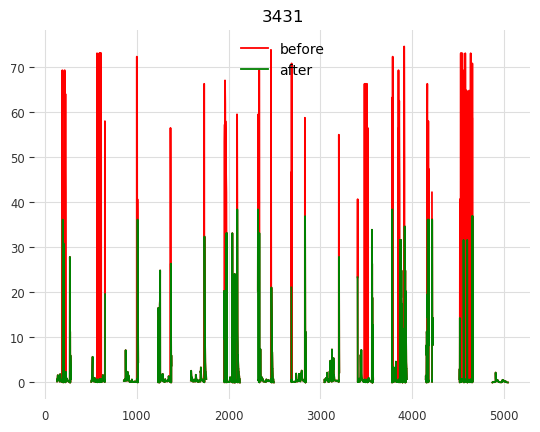

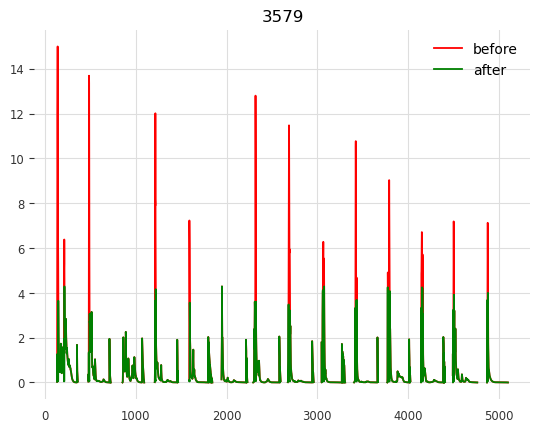

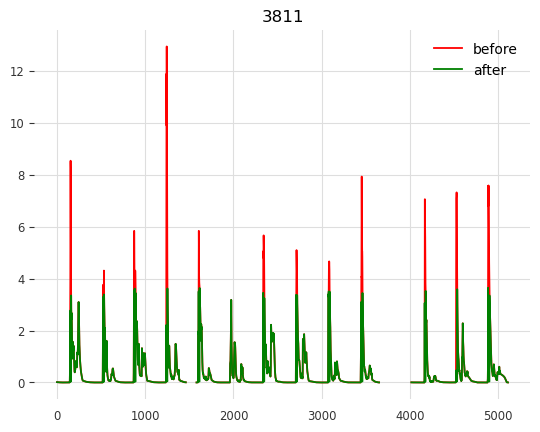

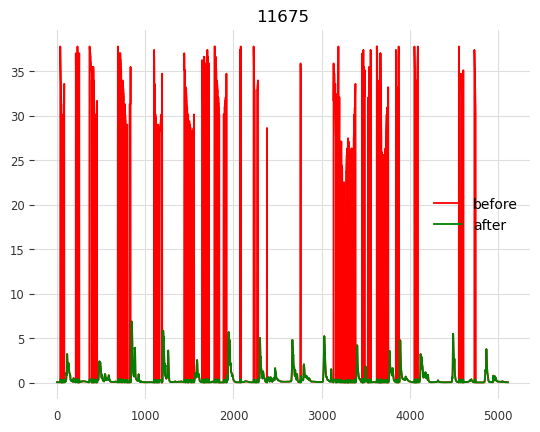

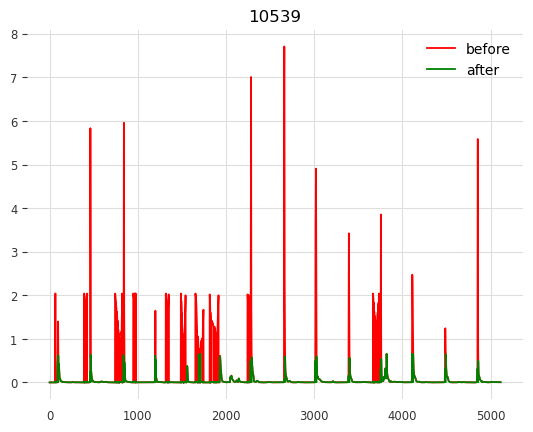

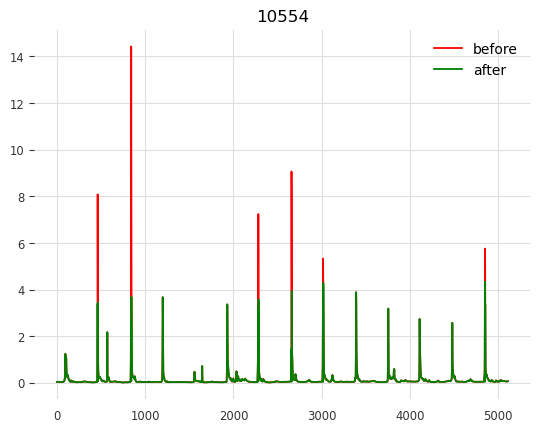

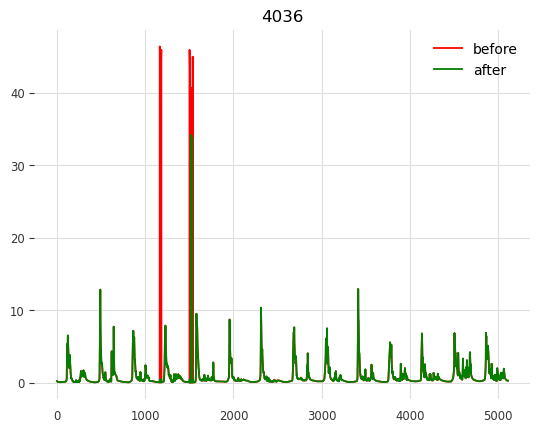

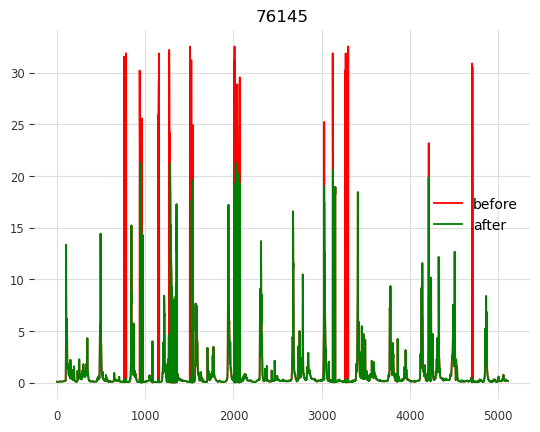

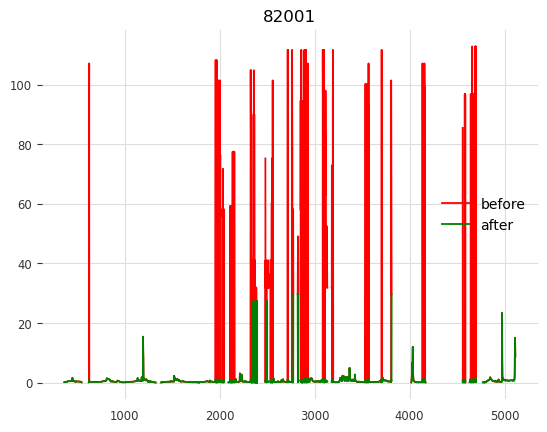

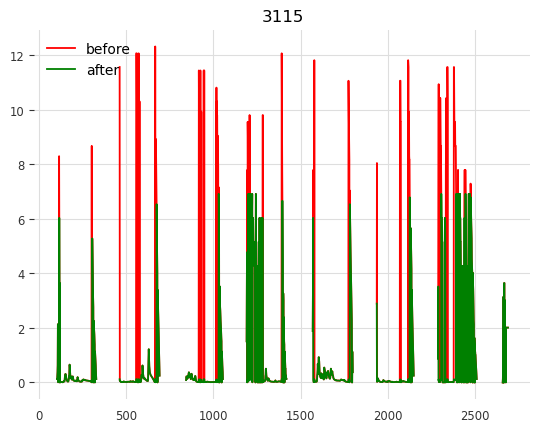

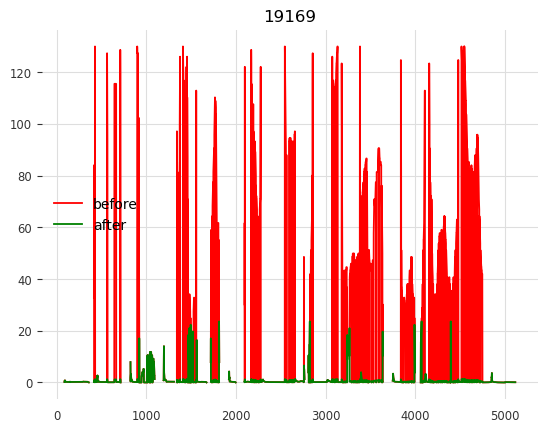

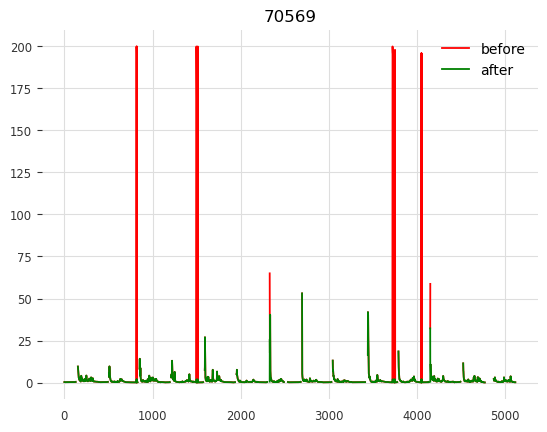

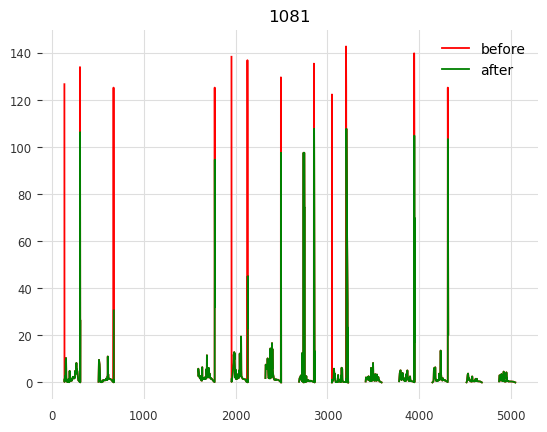

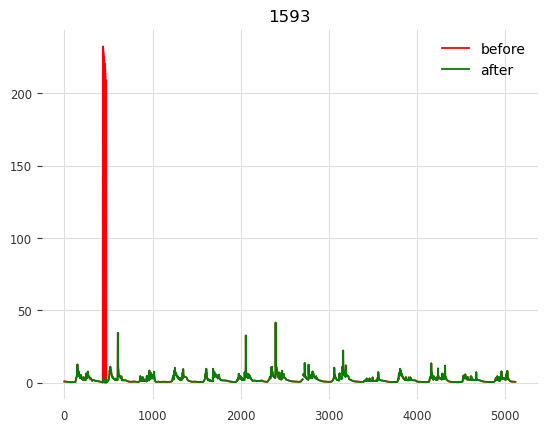

KeyboardInterrupt: 

In [33]:
import time
# creating subplot and figure


for g_id in ws_file.index:
    try:
        _file = pd.read_csv(f"../ais_parsers/ais_results_2021/{g_id}.csv")
    except FileNotFoundError:
        continue
    if (_file["q_mm_day"] > _file["q_mm_day"].quantile(0.5) * 100).sum() > 15 | _file[
        "q_mm_day"
    ].isna().all():
        fig = plt.figure()
        ax = fig.add_subplot(111)
        _file["q_mm_day"].plot(label="before", c="r", ax=ax)
        _file["q_cms_s"][_file["q_cms_s"] > _file["q_cms_s"].quantile(0.5) * 100] /= 100
        _file["q_mm_day"][
            _file["q_mm_day"] > _file["q_mm_day"].quantile(0.5) * 100
        ] /= 100
        _file["q_mm_day"].plot(label="after", c="g", ax=ax)
        plt.title(f"{g_id}")
        plt.legend()
        plt.show()

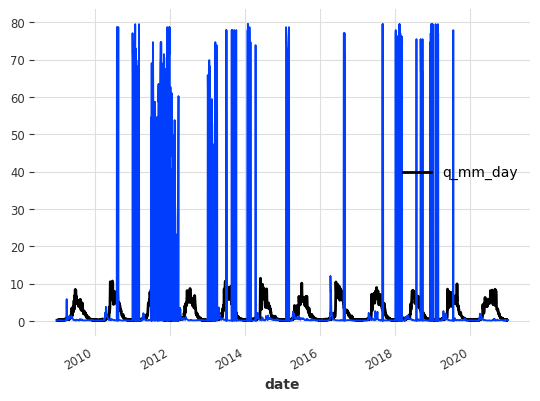

In [40]:
file = xr.open_dataset(nc_files[6]).to_dataframe()
if "index" in file.index.names:
    file.index.names = ["date", "gauge_id"]

file = file[[*meteo_input, hydro_target, "gauge_id"]]
try:
    if isinstance(static_attributes, pd.DataFrame):
        static_attributes = static_attributes[[*static_parameters]]
        gauge_static = static_attributes.loc[[gauge_id], :]
    else:
        gauge_static = None
except KeyError:
    print(f"No data for {gauge_id} !")
    # continue
if isinstance(gauge_static, pd.DataFrame):
    for col in gauge_static.columns:
        file[col] = gauge_static.loc[gauge_id, col]


pred_gauge = file[train_start:pred_end]
obs_data = deepcopy(pred_gauge.loc["2009-01-01":pred_end, "q_mm_day"])

train_target_scaler.inverse_transform(some_gauge_shit[0]).plot()
obs_data.plot()

In [41]:
file = xr.open_dataset(nc_files[0]).to_dataframe()
if "index" in file.index.names:
    file.index.names = ["date", "gauge_id"]

file = file[[*meteo_input, hydro_target, "gauge_id"]]
try:
    if isinstance(static_attributes, pd.DataFrame):
        static_attributes = static_attributes[[*static_parameters]]
        gauge_static = static_attributes.loc[[gauge_id], :]
    else:
        gauge_static = None
except KeyError:
    print(f"No data for {gauge_id} !")
    # continue
if isinstance(gauge_static, pd.DataFrame):
    for col in gauge_static.columns:
        file[col] = gauge_static.loc[gauge_id, col]


pred_gauge = file[train_start:pred_end]
obs_data = deepcopy(pred_gauge.loc[val_start:val_end, "q_mm_day"])
pred_gauge.loc[pred_start:pred_end, "q_mm_day"] = 0

# pred_gauge = pred_gauge.reset_index()


# pred_target_example = target_creator(data_frame=pred_gauge[:val_end].reset_index(),
#                                      static_parameters=static_parameters,
#                                      target_input=hydro_target)
# pred_target_example = train_target_scaler.transform(pred_target_example)
# pred_past_cov_example = covariate_creator(data_frame=pred_gauge[:val_end].reset_index(),
#                                           static_parameters=static_parameters,
#                                           meteo_input=meteo_input)
# pred_past_cov_example = train_cov_scaler.transform(pred_past_cov_example)
# pred_future_cov_example = covariate_creator(data_frame=pred_gauge[val_start:].reset_index(),
#                                             static_parameters=static_parameters,
#                                             meteo_input=meteo_input)
# pred_future_cov_example = train_cov_scaler.transform(pred_future_cov_example)

ValueError: The number of target series must be equal to the number of covariates.

In [40]:
pred_target_example

[<TimeSeries (DataArray) (date: 4018, component: 1, sample: 1)>
 array([[[-0.69736737]],
 
        [[-0.69443737]],
 
        [[-0.6949701 ]],
 
        ...,
 
        [[-0.7082883 ]],
 
        [[-0.70935376]],
 
        [[-0.7082883 ]]])
 Coordinates:
   * date       (date) datetime64[ns] 2008-01-01 2008-01-02 ... 2018-12-31
   * component  (component) object 'q_mm_day'
 Dimensions without coordinates: sample
 Attributes:
     static_covariates:  static_covariates  for_pc_sse  crp_pc_sse  inu_pc_ult...
     hierarchy:          None]

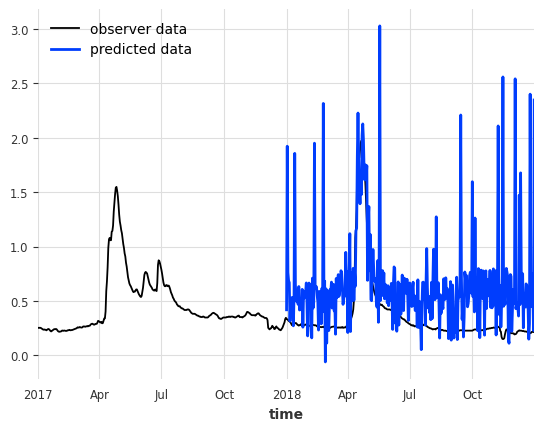

In [32]:
obs_data.plot(label="observer data")
train_target_scaler.inverse_transform(some_gauge_shit).plot(label="predicted data")

# res_df = pd.DataFrame()
# res_df['tft'] = train_target_scaler.inverse_transform(
#     some_gauge_shit).values().squeeze()
# res_df['obs'] = obs_data.values
# res_df = res_df.dropna()

# plt.title("NSE: {:.2f}".format(
#     nse(predictions=res_df['tft'],
#         targets=res_df['obs'])));

In [28]:
pred_past_cov_example

[<TimeSeries (DataArray) (date: 4749, component: 3, sample: 1)>
 array([[[-0.65822586],
         [-1.1026035 ],
         [-1.42195923]],
 
        [[-0.62320198],
         [-0.72592173],
         [-1.15307955]],
 
        [[-0.67677918],
         [-1.56438237],
         [-1.50411274]],
 
        ...,
 
        [[-0.6362706 ],
         [-0.63567316],
         [-0.50929011]],
 
        [[-0.63979971],
         [-0.90012857],
         [-0.64396881]],
 
        [[-0.62313585],
         [-0.70272991],
         [-0.32835085]]])
 Coordinates:
   * date       (date) datetime64[ns] 2008-01-01 2008-01-02 ... 2020-12-31
   * component  (component) object 'prcp_e5l' 't_max_e5l' 't_min_e5l'
 Dimensions without coordinates: sample
 Attributes:
     static_covariates:  static_covariates  for_pc_sse  crp_pc_sse  inu_pc_ult...
     hierarchy:          None]

In [14]:
for file_path in nc_files:  # [:10]
    gauge_id = file_path.split("/")[-1][:-3]
    try:
        if isinstance(static_attributes, pd.DataFrame):
            static_attributes = static_attributes[[*static_parameters]]
            gauge_static = static_attributes.loc[[gauge_id], :]
        else:
            gauge_static = None
    except KeyError:
        print(f"No data for {gauge_id} !")
        continue
    cond = file_checker(
        file_path=file_path, meteo_predictors=meteo_input, hydro_target=hydro_target
    )
    if cond:
        continue
    if gauge_id not in area_index:
        continue
    file = xr.open_dataset(file_path).to_dataframe()

731

In [ ]:
input_chunk_length

In [ ]:
some_future_shit = my_model.predict(
    n=pred_len,
    series=pred_target_example,
    past_covariates=pred_cov_example,
    future_covariates=pred_cov_example,
    verbose=True,
)

In [269]:
some_shit = my_model.historical_forecasts(
    num_samples=1,
    series=train_target_scale,
    past_covariates=train_cov_scale,
    future_covariates=pred_cov_scale,
    retrain=False,
    verbose=True,
)

Predicting: |          | 0/? [00:00<?, ?it/s]

### Future testing

In [242]:
pred_len = 700

pred_target_example = pred_target_scale_zero[0][:-pred_len]
pred_cov_example = pred_cov_scale[0]
train_cov_example = train_cov_scale[0]

val_slice = len(pred_target_scale_zero[0]) - pred_len

target_for_plot = pred_target_scale[0][val_slice:]

In [243]:
some_future_shit = my_model.predict(
    n=pred_len,
    series=pred_target_example,
    past_covariates=pred_cov_example,
    future_covariates=pred_cov_example,
    verbose=True,
)

Predicting: |          | 0/? [00:00<?, ?it/s]

In [246]:
some_future_shit[0]

<TimeSeries (DataArray) (date: 1, component: 1, sample: 1)>
array([[[-0.66764578]]])
Coordinates:
  * date       (date) datetime64[ns] 2019-02-01
  * component  (component) object 'q_mm_day'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  static_covariates  for_pc_sse  crp_pc_sse  inu_pc_ult...
    hierarchy:          None

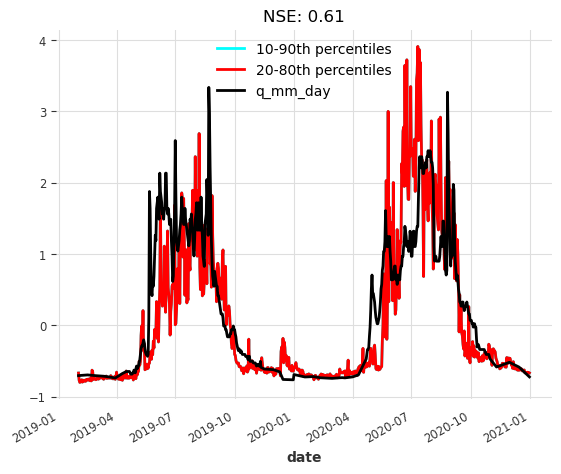

In [251]:
figsize = (9, 6)
lowest_q, low_q, high_q, highest_q = 0.1, 0.2, 0.8, 0.9
label_q_outer = f"{int(lowest_q * 100)}-{int(highest_q * 100)}th percentiles"
label_q_inner = f"{int(low_q * 100)}-{int(high_q * 100)}th percentiles"


# plot prediction with quantile ranges


some_future_shit.plot(
    low_quantile=lowest_q, high_quantile=highest_q, label=label_q_outer, color="cyan"
)
some_future_shit.plot(
    low_quantile=low_q, high_quantile=high_q, label=label_q_inner, color="r"
)
target_for_plot.plot()

plt.title(
    "NSE: {:.2f}".format(
        nse(some_future_shit.values().squeeze(), target_for_plot.values().squeeze())
    )
)
plt.legend()

In [264]:
pred_target_scale[0]

<TimeSeries (DataArray) (date: 4749, component: 1, sample: 1)>
array([[[-0.71311706]],

       [[-0.71101634]],

       [[-0.70891562]],

       ...,

       [[-0.704189  ]],

       [[-0.71311706]],

       [[-0.72151994]]])
Coordinates:
  * date       (date) datetime64[ns] 2008-01-01 2008-01-02 ... 2020-12-31
  * component  (component) object 'q_mm_day'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  static_covariates  for_pc_sse  crp_pc_sse  inu_pc_ult...
    hierarchy:          None

In [262]:
some_shit[0]

<TimeSeries (DataArray) (time: 3654, component: 1, sample: 1)>
array([[[-0.79439153]],

       [[-0.79219255]],

       [[-0.7923125 ]],

       ...,

       [[-0.78551006]],

       [[-0.76612886]],

       [[-0.78170336]]])
Coordinates:
  * time       (time) datetime64[ns] 2008-12-31 2009-01-01 ... 2019-01-01
  * component  (component) object 'q_mm_day'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  static_covariates  for_pc_sse  crp_pc_sse  inu_pc_ult...
    hierarchy:          None

<AxesSubplot:xlabel='date'>

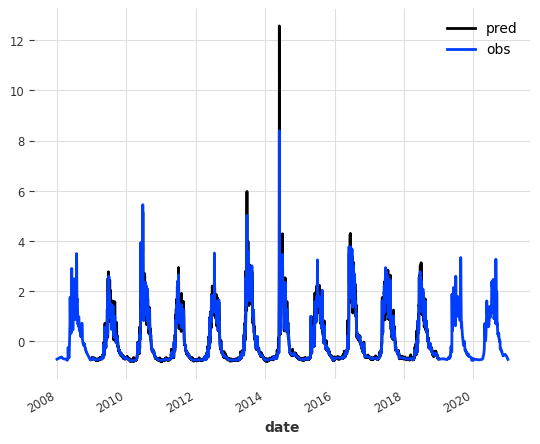

In [272]:
some_shit[0].plot(label="pred")
pred_target_scale[0].plot(label="obs")


# plt.title("NSE: {:.2f}".format(
#     nse(some_shit[0].values().squeeze(),
#         pred_target_scale[0][1095:].values().squeeze())));

In [ ]:
cov_train_val_dict = dict()
target_train_val_dict = dict()

# train period
cov_train_val_dict["train"] = list()
for g in cov_time_series:
    cov_train_val_dict["train"].append(
        g.split_after(pd.Timestamp(train_end))[0].astype(np.float32)
    )
# train period
target_train_val_dict["train"] = list()
for g in target_time_series:
    target_train_val_dict["train"].append(
        g.split_after(pd.Timestamp(train_end))[0].astype(np.float32)
    )

In [28]:
cov_train_val_dict = dict()
target_train_val_dict = dict()

train_start = "2008-01-01"
train_end = "2016-12-31"

val_start = "2017-01-01"
val_end = "2018-12-31"

pred_start = "2018-01-01"
pred_end = "2020-12-31"

# train period
cov_train_val_dict["train"] = list()
for g in cov_time_series:
    cov_train_val_dict["train"].append(
        g.split_after(pd.Timestamp(train_end))[0].astype(np.float32)
    )
# train period
target_train_val_dict["train"] = list()
for g in target_time_series:
    target_train_val_dict["train"].append(
        g.split_after(pd.Timestamp(train_end))[0].astype(np.float32)
    )

# val period
cov_train_val_dict["val"] = list()
for g in cov_time_series:
    cov_train_val_dict["val"].append(
        g.split_before(pd.Timestamp(val_start))[1]
        .split_after(pd.Timestamp(val_end))[0]
        .astype(np.float32)
    )
# val period
target_train_val_dict["val"] = list()
for g in target_time_series:
    target_train_val_dict["val"].append(
        g.split_before(pd.Timestamp(val_start))[1]
        .split_after(pd.Timestamp(val_end))[0]
        .astype(np.float32)
    )

# test period
cov_train_val_dict["test"] = list()
for g in cov_time_series:
    cov_train_val_dict["test"].append(
        g.split_before(pd.Timestamp(pred_start))[1]
        .split_after(pd.Timestamp(pred_end))[0]
        .astype(np.float32)
    )
# test period
target_train_val_dict["test"] = list()
for g in target_time_series:
    test_split = (
        g.split_before(pd.Timestamp(pred_start))[1]
        .split_after(pd.Timestamp(pred_end))[0]
        .astype(np.float32)
    )
    target_train_val_dict["test"].append(test_split)

In [12]:
my_model.fit(
    target_train_val_dict["train"],
    future_covariates=cov_train_val_dict["train"],
    verbose=True,
)

A Jupyter Widget

TFTModel(hidden_size=64, lstm_layers=1, num_attention_heads=4, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.4, hidden_continuous_size=8, categorical_embedding_sizes=None, add_relative_index=False, loss_fn=None, likelihood=QuantileRegression(quantiles: Optional[List[float]] = None), norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=365, output_chunk_length=7, batch_size=128, n_epochs=10, add_encoders=None, random_state=42)

In [19]:
# before starting, we define some constants
num_samples = 24

figsize = (9, 6)
lowest_q, low_q, high_q, highest_q = 0.01, 0.1, 0.9, 0.99
label_q_outer = f"{int(lowest_q * 100)}-{int(highest_q * 100)}th percentiles"
label_q_inner = f"{int(low_q * 100)}-{int(high_q * 100)}th percentiles"

In [ ]:
my_model.pre

In [ ]:
my_model.historical_forecasts(
    num_samples=num_samples,
    series=target_train_val_dict["test"],
    past_covariates=cov_train_val_dict["test"],
    future_covariates=cov_train_val_dict["test"],
)

In [ ]:
my_model.predict(
    n=7,
    num_samples=num_samples,
    series=target_train_val_dict["test"],
    past_covariates=cov_train_val_dict["test"],
    future_covariates=cov_train_val_dict["test"],
)

In [17]:
def eval_model(model, n, actual_series, val_series):
    pred_series = model.predict(n=n, num_samples=10)

    # plot actual series
    plt.figure(figsize=figsize)
    actual_series[: pred_series.end_time()].plot(label="actual")

    # plot prediction with quantile ranges
    pred_series.plot(
        low_quantile=lowest_q, high_quantile=highest_q, label=label_q_outer
    )
    pred_series.plot(low_quantile=low_q, high_quantile=high_q, label=label_q_inner)

    plt.title("MAPE: {:.2f}%".format(mape(val_series, pred_series)))
    plt.legend()


eval_model(my_model, 7, target_time_series, target_train_val_dict["val"])

ValueError: Input `series` must be provided. This is the result either from fitting on multiple series, or from not having fit the model yet.